In [1]:
import pandas as pd
import numpy as np
import re
import os
import datetime
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from statsmodels.discrete.discrete_model import NegativeBinomial
from patsy.contrasts import Treatment
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from pickle import dump

In [2]:
"""
Define I/O info
"""
# path to input directory
inDIR = 'C:/Users/sean.kearney/OneDrive - USDA/Documents/Projects/GPS_v_hetgen/data/'
# file name of gridded path intensity data (output from gps_to_gridded_path_intensity.ipynb)
griddata_2016_f = '2016_grazing_time_gridded_all_extracted.csv'
griddata_2017_f = '2017_grazing_time_gridded_all_extracted.csv'
griddata_2018_f = '2018_grazing_time_gridded_all_extracted.csv'

# path to output directory
outDIR = 'C:/Users/sean.kearney/OneDrive - USDA/Documents/Projects/GPS_v_hetgen/models/'

if not os.path.exists(outDIR):
    os.mkdir(outDIR)

if not os.path.exists(os.path.join(outDIR, 'seas/')):
    os.mkdir(os.path.join(outDIR, 'seas/'))
    
if not os.path.exists(os.path.join(outDIR, 'results_tables/')):
    os.mkdir(os.path.join(outDIR, 'results_tables/'))

In [3]:
"""
Load data and check data types
"""
df_wkly_grid_2016 = pd.read_csv(os.path.join(inDIR, griddata_2016_f))
df_wkly_grid_2017 = pd.read_csv(os.path.join(inDIR, griddata_2017_f))
df_wkly_grid_2018 = pd.read_csv(os.path.join(inDIR, griddata_2018_f))

df_wkly_grid_full = df_wkly_grid_2016.append(df_wkly_grid_2017.append(df_wkly_grid_2018))
display(df_wkly_grid_full.dtypes)

index_id          int64
mod_data         object
week              int64
Pasture          object
Steer_ID         object
UTM_X           float64
UTM_Y           float64
grazing_secs    float64
TPC             float64
dFence          float64
dTank           float64
PC_dmt           object
PC_pct          float64
PC_div          float64
Biomass         float64
CP              float64
DOM             float64
dCorner         float64
TPC_c            object
dtype: object

In [4]:
"""
Add season to dataset based on week and year based on Steer_ID
"""

def season_func(wk):
    if wk <= 26:
        return 'early'
    elif wk <= 32:
        return 'mid'
    elif wk >= 33:
        return 'late'

df_wkly_grid_full['season'] = df_wkly_grid_full['week'].apply(lambda x: season_func(x))
df_wkly_grid_full['season'] = pd.Categorical(df_wkly_grid_full['season'], ['early', 'mid', 'late'])
df_wkly_grid_full['Year'] = df_wkly_grid_full['Steer_ID'].apply(lambda x: int(x.split('_')[-1]))

In [5]:
"""
Calculate all pasture combos where at least n-1 pasture are available 4 weeks per season
"""
df_seas_unique = df_wkly_grid_full.groupby(['Year', 'week']).agg({'Pasture': lambda x: x.unique(),
                                                                  'Steer_ID': lambda x: x.unique()}).reset_index()
df_seas = df_seas_unique.groupby(['Year', 'week']).agg(
    {'Pasture': lambda x: [i for i in list(df_wkly_grid_full['Pasture'].unique()) if all(i in y for y in x)],
     'Steer_ID': lambda x: [i for i in list(df_wkly_grid_full['Steer_ID'].unique()) if all(i in y for y in x)]}).reset_index()
df_seas['season'] = df_seas['week'].apply(lambda x: season_func(x))
df_combo_results = pd.DataFrame(columns=['n_pasture', 'past_list', 'Year', 'season', 'n_weeks', 'week_list'])
for r in tqdm(range(5, 10)):
    past_combos = list(itertools.combinations(df_wkly_grid_full['Pasture'].unique(), r))
    for combo in past_combos:
        #print(list(combo))
        # create mask of final weeks based on pastures
        wk_mask = [sum(j in i for j in list(combo)) > (r-2) for i in df_seas['Pasture']]
        df_tmp = df_seas[wk_mask].groupby(['Year', 'season'])['week'].count().reset_index()
        df_tmp['n_pasture'] = r
        df_tmp['past_list'] = pd.Series(list(np.tile(list(combo), (len(df_tmp), 1)).astype('object')))
        df_tmp['week_list'] = pd.Series(list(np.tile(list(df_seas[wk_mask]['week'].unique()), (len(df_tmp), 1)).astype('object')))
        df_tmp = df_tmp.rename(columns={'week': 'n_weeks'})
        for (yr, seas), grp_data in df_seas.groupby(['Year', 'season']):
            if len(df_tmp[(df_tmp['Year'] == yr) & (df_tmp['season'] == seas)]) == 0:
                #print(yr, seas)
                df_tmp = df_tmp.append(pd.DataFrame({'Year': yr,
                                                     'season': seas,
                                                     'n_weeks': 0,
                                                     'n_pasture': r,
                                                     'past_list': pd.Series(list(np.tile(list(combo), (1, 1)).astype('object'))),
                                                     'week_list': pd.Series(list(np.tile(list(df_seas[wk_mask]['week'].unique()), (1, 1)).astype('object')))}))
        df_combo_results = df_combo_results.append(df_tmp)
    df_combo_results['past_list_str'] = df_combo_results['past_list'].apply(lambda x: '_'.join(x))

  0%|          | 0/5 [00:00<?, ?it/s]

In [6]:
min_weeks = 4
past_combos_gt_n = df_combo_results.groupby(
    'past_list_str')['n_weeks'].min()[df_combo_results.groupby(
    'past_list_str')['n_weeks'].min() >= min_weeks].index.values
max_pasts = df_combo_results[df_combo_results['past_list_str'].isin(past_combos_gt_n)]['n_pasture'].max()
display(df_combo_results[(df_combo_results['past_list_str'].isin(past_combos_gt_n)) & 
                         (df_combo_results['n_pasture'] == max_pasts)])

,n_pasture,past_list,Year,season,n_weeks,week_list,past_list_str
0,7,"[7NW, 17N, 20SE, 31E, 26E, 15E, 25SE]",2016,early,5,"[21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 3...",7NW_17N_20SE_31E_26E_15E_25SE
1,7,"[7NW, 17N, 20SE, 31E, 26E, 15E, 25SE]",2016,late,6,"[21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 3...",7NW_17N_20SE_31E_26E_15E_25SE
2,7,"[7NW, 17N, 20SE, 31E, 26E, 15E, 25SE]",2016,mid,6,"[21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 3...",7NW_17N_20SE_31E_26E_15E_25SE
3,7,"[7NW, 17N, 20SE, 31E, 26E, 15E, 25SE]",2017,early,4,"[21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 3...",7NW_17N_20SE_31E_26E_15E_25SE
4,7,"[7NW, 17N, 20SE, 31E, 26E, 15E, 25SE]",2017,late,4,"[21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 3...",7NW_17N_20SE_31E_26E_15E_25SE
5,7,"[7NW, 17N, 20SE, 31E, 26E, 15E, 25SE]",2017,mid,5,"[21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 3...",7NW_17N_20SE_31E_26E_15E_25SE
6,7,"[7NW, 17N, 20SE, 31E, 26E, 15E, 25SE]",2018,early,5,"[21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 3...",7NW_17N_20SE_31E_26E_15E_25SE
7,7,"[7NW, 17N, 20SE, 31E, 26E, 15E, 25SE]",2018,late,5,"[21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 3...",7NW_17N_20SE_31E_26E_15E_25SE
8,7,"[7NW, 17N, 20SE, 31E, 26E, 15E, 25SE]",2018,mid,4,"[21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 3...",7NW_17N_20SE_31E_26E_15E_25SE


In [7]:
train_pasts = df_combo_results[(df_combo_results['past_list_str'].isin(past_combos_gt_n)) & 
                             (df_combo_results['n_pasture'] == max_pasts)]['past_list_str'].str.split('_')[0]
train_weeks = df_combo_results[(df_combo_results['past_list_str'].isin(past_combos_gt_n)) & 
                             (df_combo_results['n_pasture'] == max_pasts)]['week_list'][0]
df_wkly_grid_full['mod_data'] = 'test'
df_wkly_grid_full.loc[(df_wkly_grid_full['Pasture'].isin(train_pasts)) &
                      (df_wkly_grid_full['week'].isin(train_weeks)), 'mod_data'] = 'train'

In [8]:
df_wkly_grid_full.groupby(['Year', 'mod_data'])['Pasture'].unique()

Year  mod_data
2016  test                                       [24W, 5E, 19N]
      train               [7NW, 17N, 20SE, 31E, 26E, 15E, 25SE]
2017  test                       [24W, 15E, 26E, 25SE, 5E, 19N]
      train               [17N, 20SE, 15E, 25SE, 31E, 7NW, 26E]
2018  test        [24W, 26E, 25SE, 5E, 15E, 19N, 7NW, 17N, 31E]
      train               [7NW, 17N, 15E, 26E, 25SE, 31E, 20SE]
Name: Pasture, dtype: object

In [9]:
"""
Remove data in corners and near water tanks
"""
df_wkly_grid_full = df_wkly_grid_full[df_wkly_grid_full['dTank'] > 60]
df_wkly_grid_full = df_wkly_grid_full[df_wkly_grid_full['dCorner'] > 60]
df_wkly_grid_full = df_wkly_grid_full[df_wkly_grid_full['dFence'] > 0]

'Number of grazing values > 10,000 = 1'

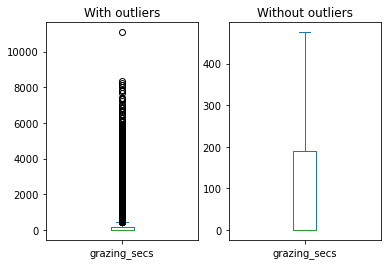

In [10]:
"""
Check grazing intensity values for further cleaning
"""
max_graze_secs = 10000
fig, axs = plt.subplots(nrows=1, ncols=2)
df_wkly_grid_full['grazing_secs'].plot.box(showfliers=True, ax=axs[0], title='With outliers')
df_wkly_grid_full['grazing_secs'].plot.box(showfliers=False, ax=axs[1], title='Without outliers')
display('Number of grazing values > ' + "{:,}".format(max_graze_secs) + ' = ' + "{:,}".format(
    len(df_wkly_grid_full[df_wkly_grid_full['grazing_secs'] > max_graze_secs])))

In [11]:
# drop grid cells with seemingly erroneous grazing intensity
df_wkly_grid_full = df_wkly_grid_full[df_wkly_grid_full['grazing_secs'] < max_graze_secs].copy(deep=True)

# convert grazing secs to integer
df_wkly_grid_full['grazing_secs'] = df_wkly_grid_full['grazing_secs'].astype('int')

In [12]:
"""
Flag and remove any outliers beyond last bin with only one pixel
"""

secs_bin_size = 60 * 5

def flag_graze_outliers(x, bins=np.arange(-5, max_graze_secs, secs_bin_size)):
    try:
        groups = x.groupby(pd.cut(x, bins, include_lowest=False))
        one_bins = bins[:-1][(groups.count() == 1).values] 
        gt_one_bins = bins[:-1][(groups.count() > 1).values] 
        last_one_bin = np.min([np.max(gt_one_bins) + secs_bin_size, np.max([np.min(one_bins), np.max(gt_one_bins)])])
        return (x >= last_one_bin).astype('int')
    except ValueError:
        return 0

df_wkly_grid_full['grazing_secs_outlier'] = df_wkly_grid_full.groupby(['Year', 'season', 'Pasture'])['grazing_secs'].transform(flag_graze_outliers)
print('Stats of grid cells removed across all steer-weeks:')
display(df_wkly_grid_full.groupby(['Year', 'season', 'Pasture'])['grazing_secs_outlier'].sum().describe())

Stats of grid cells removed across all steer-weeks:


count    90.000000
mean      2.133333
std       1.697321
min       0.000000
25%       1.000000
50%       2.000000
75%       3.000000
max       8.000000
Name: grazing_secs_outlier, dtype: float64

In [13]:
# remove grazing outliers
df_wkly_grid_full = df_wkly_grid_full[df_wkly_grid_full['grazing_secs_outlier'] == 0]

In [14]:
"""
Scale variables if desired
"""
from sklearn.preprocessing import StandardScaler
scale_vars = True
scaler = StandardScaler()
if scale_vars:
    for c in ['dFence', 'dTank', 'Biomass', 'CP', 'PC_div']:
        for seas in ['early', 'mid', 'late']:
            for yr in df_wkly_grid_full['Year'].unique():
                scaler.fit(df_wkly_grid_full.loc[(df_wkly_grid_full['season'] == seas) & 
                                                 (df_wkly_grid_full['mod_data'] == 'train') &
                                                 (df_wkly_grid_full['Year'] == yr), c].values.reshape(-1, 1))
                with open(os.path.join(outDIR, 'scaler_' + str(yr) + '_' + seas + '_' + c + '.pkl'), 'wb') as f:
                    dump(scaler, f)
                vals_scaled_tmp = scaler.transform(
                    df_wkly_grid_full.loc[(df_wkly_grid_full['season'] == seas) &
                                          (df_wkly_grid_full['Year'] == yr), c].values.reshape(-1, 1)).flatten()
                df_wkly_grid_full.loc[(df_wkly_grid_full['season'] == seas) &
                                      (df_wkly_grid_full['Year'] == yr), c + '_orig'] = df_wkly_grid_full.loc[(df_wkly_grid_full['season'] == seas) &
                                                                       (df_wkly_grid_full['Year'] == yr), c].values
                df_wkly_grid_full.loc[(df_wkly_grid_full['season'] == seas) &
                                      (df_wkly_grid_full['Year'] == yr), c] = vals_scaled_tmp
#for c in ['dFence', 'dTank', 'Biomass', 'CP', 'PC_div']:
#    df_wkly_grid_full.loc[:, c] = df_wkly_grid_full.groupby(['season'])[c].transform(
#        lambda x: scaler.fit_transform(x.values.reshape(-1, 1)).flatten())
    #scaler.fit_transform(df_wkly_grid_full[c].values.reshape(-1, 1)).flatten()#.transform(
#        lambda x: scaler.fit_transform(x.values.reshape(-1, 1)).flatten())

In [15]:
df_wkly_grid_full['season_str'] = df_wkly_grid_full['season'].astype(str)#.value_counts()

In [16]:
"""
Organize dataset into training and testing data
"""
df_wkly_grid_test = df_wkly_grid_full[df_wkly_grid_full['mod_data'] == 'test'].groupby(['Pasture',
                                                                                        'week',
                                                                                        'season_str',
                                                                                        'Year',
                                                                                        'UTM_X',
                                                                                        'UTM_Y']).agg(func={
    'Biomass': np.mean,
    'CP': np.mean,
    'dFence': np.mean,
    'dTank': np.mean,
    'PC_div': np.mean,
    'Biomass_orig': np.mean,
    'CP_orig': np.mean,
    'dFence_orig': np.mean,
    'dTank_orig': np.mean,
    'PC_div_orig': np.mean,
    'TPC_c': lambda x: x.iloc[0],
    'PC_dmt': lambda x: x.iloc[0],
    'grazing_secs': np.sum,
    'mod_data': lambda x: x.iloc[0]
}).reset_index()

df_wkly_grid = df_wkly_grid_full[df_wkly_grid_full['mod_data'] == 'train'].groupby(['Pasture',
                                                                                    'week',
                                                                                        'season_str',
                                                                                        'Year',
                                                                                        'UTM_X',
                                                                                        'UTM_Y']).agg(func={
    'Biomass': np.mean,
    'CP': np.mean,
    'dFence': np.mean,
    'dTank': np.mean,
    'PC_div': np.mean,
    'Biomass_orig': np.mean,
    'CP_orig': np.mean,
    'dFence_orig': np.mean,
    'dTank_orig': np.mean,
    'PC_div_orig': np.mean,
    'TPC_c': lambda x: x.iloc[0],
    'PC_dmt': lambda x: x.iloc[0],
    'grazing_secs': np.sum,
    'mod_data': lambda x: x.iloc[0]
}).reset_index()

In [17]:
"""
Calculate total weekly grazing seconds per pasture-season to use as offset to account for missing data
"""
df_wkly_grid_test.loc[:, 'grazing_wkly_sum'] = df_wkly_grid_test.groupby(['Pasture',
                                                                          'week',
                                                                          'Year',
                                                                          'season_str'])['grazing_secs'].transform('sum').values

df_wkly_grid.loc[:, 'grazing_wkly_sum'] = df_wkly_grid.groupby(['Pasture',
                                                                'week',
                                                                 'Year',
                                                                 'season_str'])['grazing_secs'].transform('sum').values


In [18]:
df_wkly_grid.groupby(['Pasture',
                      'week',
                          'Year',
                          'season_str'])['grazing_wkly_sum'].value_counts()

Pasture  week  Year  season_str  grazing_wkly_sum
15E      20    2017  early       354769              1343
               2018  early       165761              1343
         21    2016  early       122146              1342
               2017  early       372794              1343
               2018  early       144125              1343
                                                     ... 
7NW      38    2017  late        196386              1332
               2018  late        215342              1331
         39    2016  late        247657              1332
               2017  late        266910              1332
               2018  late        162144              1332
Name: grazing_wkly_sum, Length: 333, dtype: int64

In [19]:
"""
Calculate grazing frequency relative to expected with perfectly even grazing
"""
df_wkly_grid.loc[:, 'grazing_rel_freq'] = df_wkly_grid['grazing_secs'] / (df_wkly_grid['grazing_wkly_sum'] / 
                                                                             df_wkly_grid.groupby(
                                                                                 ['Pasture', 
                                                                                  'week',
                                                                                  'Year',
                                                                                  'season_str'])['grazing_secs'].transform('count'))
df_wkly_grid['grazing_rel_freq'].describe()

count    450281.000000
mean          1.000000
std           1.722011
min           0.000000
25%           0.000000
50%           0.273973
75%           1.344711
max          42.332618
Name: grazing_rel_freq, dtype: float64

[Text(0.0, 1, 'None'),
 Text(111.1111111111111, 1, ''),
 Text(222.2222222222222, 1, 'Low'),
 Text(333.3333333333333, 1, ''),
 Text(444.4444444444444, 1, 'Avg.'),
 Text(555.5555555555555, 1, ''),
 Text(666.6666666666666, 1, 'Hi'),
 Text(777.7777777777777, 1, ''),
 Text(888.8888888888888, 1, 'V. Hi'),
 Text(1000.0, 1, '')]

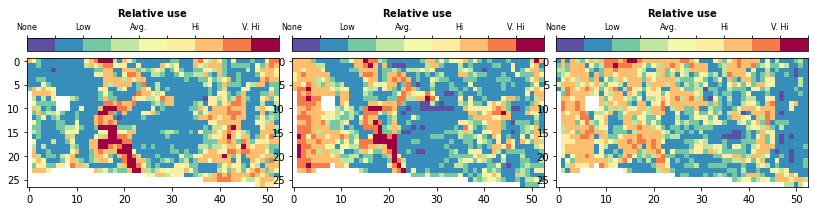

In [45]:
import xarray as xr
xr_dat_past = df_wkly_grid[df_wkly_grid['Pasture'] == '17N'].set_index(['Year', 'season_str',
                                                                        'UTM_Y', 'UTM_X']).to_xarray()

from matplotlib.gridspec import GridSpec
from matplotlib import colors, cm
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1 import make_axes_locatable

rel_use_breaks = [0, 0.001, 0.5, 0.75, 0.9, 1.0, 1.25, 2.5, 4.0, 1000]
rel_use_labels = ['None', '', 'Low', '', 'Avg.', '', 'Hi', '', 'V. Hi', '']
rel_use_cmap = cm.get_cmap('Spectral_r', len(rel_use_breaks))
res_use_patches =[mpatches.Patch(color=rel_use_cmap(i), 
                                   label=rel_use_labels[i]) for i in np.arange(len(rel_use_labels))]
# Create the colormap
cmap_rel_use = colors.LinearSegmentedColormap.from_list(
            'Relative use', [rel_use_cmap(i) for i in np.arange(len(rel_use_labels))],
    N=len(rel_use_labels))
norm_rel_use = colors.BoundaryNorm(rel_use_breaks, len(rel_use_breaks))

yr = 2016
xr_dat_early = xr_dat_past.sel(Year=yr, season_str='early')
xr_dat_mid = xr_dat_past.sel(Year=yr, season_str='mid')
xr_dat_late = xr_dat_past.sel(Year=yr, season_str='late')

cax_fsize=8
cax_title_fsize=10
cax_pad=0.10

fig = plt.figure(figsize=(14, 10))

gs1 = GridSpec(1, 3, top=0.98, bottom=0.65, wspace=0.05)
ax1 = fig.add_subplot(gs1[0])
ax2 = fig.add_subplot(gs1[1])
ax3 = fig.add_subplot(gs1[2])
im1 = ax1.imshow(xr_dat_early['grazing_rel_freq'].sortby('UTM_Y', ascending=False).data, 
                 cmap=cmap_rel_use, norm=norm_rel_use)
divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes('top', size='10%', pad=cax_pad)
cbar1 = fig.colorbar(im1, cax=cax1, orientation='horizontal')
cax1.xaxis.set_ticks_position('top')
cax1.set_title("$\\bf{Relative\ use}$", fontsize=10)
cbar1.ax.tick_params(labelsize=8)
cbar1.ax.set_xticklabels(rel_use_labels)

im2 = ax2.imshow(xr_dat_mid['grazing_rel_freq'].sortby('UTM_Y', ascending=False).data, 
                 cmap=cmap_rel_use, norm=norm_rel_use)
divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes('top', size='10%', pad=cax_pad)
cbar2 = fig.colorbar(im2, cax=cax2, orientation='horizontal')
cax2.xaxis.set_ticks_position('top')
cax2.set_title("$\\bf{Relative\ use}$", fontsize=10)
cbar2.ax.tick_params(labelsize=8)
cbar2.ax.set_xticklabels(rel_use_labels)

im3 = ax3.imshow(xr_dat_late['grazing_rel_freq'].sortby('UTM_Y', ascending=False).data, 
                 cmap=cmap_rel_use, norm=norm_rel_use)
divider3 = make_axes_locatable(ax3)
cax3 = divider3.append_axes('top', size='10%', pad=cax_pad)
cbar3 = fig.colorbar(im3, cax=cax3, orientation='horizontal')
cax3.xaxis.set_ticks_position('top')
cax3.set_title("$\\bf{Relative\ use}$", fontsize=10)
cbar3.ax.tick_params(labelsize=8)
cbar3.ax.set_xticklabels(rel_use_labels)

In [21]:
"""
Check for very rare plant community classes by pasture
"""
pc_dmt_summary = df_wkly_grid.groupby(['Pasture', 'season_str'])['PC_dmt'].value_counts().groupby(
    ['Pasture', 'PC_dmt']).max().rename('value').to_frame().reset_index().pivot(index='PC_dmt', columns='Pasture')['value']
pc_dmt_summary['Total'] = pc_dmt_summary.sum(axis=1)
display(pc_dmt_summary)

Pasture,15E,17N,20SE,25SE,26E,31E,7NW,Total
PC_dmt,,,,,,,,
Bare,NaN,NaN,NaN,16.0,NaN,NaN,NaN,16.0
Bare_veg,51.0,17.0,486.0,16.0,48.0,170.0,34.0,822.0
C3,NaN,391.0,8154.0,NaN,48.0,221.0,17.0,8831.0
C3_C4_mix,5746.0,8636.0,5922.0,5216.0,1375.0,11813.0,15639.0,54347.0
C4,17034.0,5661.0,4229.0,15792.0,18944.0,13123.0,5882.0,80665.0
Saltgrass,NaN,6919.0,5544.0,NaN,NaN,68.0,849.0,13380.0
Shrub,NaN,34.0,252.0,NaN,NaN,NaN,187.0,473.0
UNK,NaN,170.0,162.0,144.0,271.0,187.0,34.0,968.0


In [22]:
"""
Check for very rare topographic position classes by pasture
"""
tpc_dmt_summary = df_wkly_grid.groupby(['Pasture', 'season_str'])['TPC_c'].value_counts().groupby(
    ['Pasture', 'TPC_c']).max().rename('value').to_frame().reset_index().pivot(index='TPC_c', columns='Pasture')['value']
tpc_dmt_summary['Total'] = tpc_dmt_summary.sum(axis=1)
display(tpc_dmt_summary)

Pasture,15E,17N,20SE,25SE,26E,31E,7NW,Total
TPC_c,,,,,,,,
Flat Plains,5542.0,2516.0,11447.0,4256.0,12784.0,2244.0,15708.0,54497.0
Highlands,4590.0,4607.0,774.0,3328.0,1392.0,7752.0,1190.0,23633.0
Lowlands,5474.0,10114.0,7848.0,7184.0,2622.0,6746.0,2820.0,42808.0
Open Slopes,7157.0,4097.0,4680.0,6176.0,3871.0,8568.0,2924.0,37473.0
Other,68.0,493.0,NaN,240.0,16.0,272.0,NaN,1089.0


In [24]:
"""
Combine rare classes to 'Other'
"""
#df_wkly_grid[df_wkly_grid['PC_dmt'].isin(['Bare', 'Bare_veg', 'UNK', 'Shrub'])] = 'Other'
df_wkly_grid['PC_dmt'].replace({'Bare_veg': 'Other', 'Bare': 'Other', 'UNK': 'Other', 'Shrub': 'Other'}, 
                               inplace=True)
#df_wkly_grid = df_wkly_grid[~df_wkly_grid['TPC_c'].isin(['Other'])]

# print final class numbers
tpc_dmt_summary2 = df_wkly_grid.groupby(['Pasture', 'week', 'season_str'])['TPC_c'].value_counts().groupby(
    ['Pasture', 'TPC_c']).max().rename('value').to_frame().reset_index().pivot(index='TPC_c', columns='Pasture')['value']
tpc_dmt_summary2['Total'] = tpc_dmt_summary2.sum(axis=1)
display(tpc_dmt_summary2)

print('\n')

pc_dmt_summary2 = df_wkly_grid.groupby(['Pasture', 'week', 'season_str'])['PC_dmt'].value_counts().groupby(
    ['Pasture', 'PC_dmt']).max().rename('value').to_frame().reset_index().pivot(index='PC_dmt', columns='Pasture')['value']
pc_dmt_summary2['Total'] = pc_dmt_summary2.sum(axis=1)
display(pc_dmt_summary2)

Pasture,15E,17N,20SE,25SE,26E,31E,7NW,Total
TPC_c,,,,,,,,
Flat Plains,978.0,444.0,1908.0,798.0,2397.0,396.0,2772.0,9693.0
Highlands,810.0,813.0,129.0,624.0,261.0,1368.0,210.0,4215.0
Lowlands,966.0,1785.0,1308.0,1347.0,492.0,1191.0,498.0,7587.0
Open Slopes,1263.0,723.0,780.0,1158.0,726.0,1512.0,516.0,6678.0
Other,12.0,87.0,NaN,45.0,3.0,48.0,NaN,195.0


Pasture,15E,17N,20SE,25SE,26E,31E,7NW,Total
PC_dmt,,,,,,,,
C3,NaN,69.0,1359.0,NaN,9.0,39.0,3.0,1479.0
C3_C4_mix,1014.0,1524.0,987.0,978.0,258.0,2085.0,2760.0,9606.0
C4,3006.0,999.0,705.0,2961.0,3552.0,2316.0,1038.0,14577.0
Other,9.0,39.0,150.0,33.0,60.0,63.0,45.0,399.0
Saltgrass,NaN,1221.0,924.0,NaN,NaN,12.0,150.0,2307.0


In [25]:
"""
Save training data for optional analysis in R
"""
#df_wkly_grid.to_csv(inDIR + 'training_grazing_time_gridded.csv', index=False)

In [26]:
min_class_n = 10
fit_method = 'bfgs'
max_iters = 1000
aicw_func = lambda x: np.exp(-0.5 * (x - x.min())) / np.sum(np.exp(-0.5 * (x - x.min())))
aicd_func = lambda x: x - x.min()

m0 = 'grazing_secs ~ dFence + dTank'
m1 = m0 + ' + C(TPC_c, Treatment(reference="Flat Plains"))'
#m2a = m0 + ' + Biomass'
m2a = m0 + ' + Biomass + I(Biomass**2)'
m2b = m0 + ' + CP'
#m2d = m2a + ' + CP' 
#m2e = m2a + ' + CP + Biomass:CP'
m2c = m2a + ' + CP'
m2d = m2a + ' + CP + Biomass:CP + I(Biomass**2):CP'
m3a = m0 + ' + C(PC_dmt, Treatment(reference="C3_C4_mix"))'
m3b = m0 + ' + PC_div'
m3c = m0 + ' + C(PC_dmt, Treatment(reference="C3_C4_mix")) + PC_div'
m3d = m0 + ' + C(PC_dmt, Treatment(reference="C3_C4_mix")) * PC_div'

model_dict = {
    'M0': m0,
    'M1': m1,
    'M2a': m2a,
    'M2b': m2b,
    'M2c': m2c,
    'M2d': m2d,
    #'M2e': m2e,
    #'M2f': m2f,
    #'M2g': m2g,
    'M3a': m3a,
    'M3b': m3b,
    'M3c': m3c,
    'M3d': m3d
}

In [27]:
"""
Run the initial candidate models
"""
df_results = pd.DataFrame(columns=['Year', 'season', 'week', 'Pasture', 'model', 'formula', 'AIC'])
idx = 0
for group in tqdm(df_wkly_grid.groupby(['Year', 'season_str', 'week', 'Pasture'])):
    # drop NANs
    data = group[1].dropna(axis=0, how='any')
    
    # remove any locations related to a class with fewer than N observations
    data = data[~data['PC_dmt'].isin(
        data['PC_dmt'].value_counts().index[data['PC_dmt'].value_counts() < min_class_n])]
    data = data[~data['TPC_c'].isin(
        data['TPC_c'].value_counts().index[data['TPC_c'].value_counts() < min_class_n])]
       
    df_results_tmp = pd.DataFrame(columns=['season_str', 'week', 'Pasture', 'model', 'formula', 'AIC'])
    
    # run initial models for negative binomial
    for i in model_dict:
        form = model_dict[i]
        #print('NB: ' + form)
        try:
            md_tmp3 = NegativeBinomial.from_formula(form, data, 
                                                    offset=np.log(data['grazing_wkly_sum']), missing='drop')
            mdf_tmp3 = md_tmp3.fit(maxiter=max_iters, method=fit_method, disp=False)
            if mdf_tmp3.mle_retvals['converged']:
                aic_tmp = round(mdf_tmp3.aic, 2)
            else:
                aic_tmp = np.nan
        except (ValueError, np.linalg.LinAlgError):
            aic_tmp = np.nan
        df_tmp = pd.DataFrame({
            'Year': group[0][0],
            'season_str': group[0][1],
            'week': group[0][2],
            'Pasture': group[0][3],
            'model': i,
            'formula': form,
            'AIC': aic_tmp
        }, index=[idx])
        df_results_tmp = df_results_tmp.append(df_tmp)
        idx += 1
        
    df_results = df_results.append(df_results_tmp)
df_results['season'] = pd.Categorical(df_results['season_str'], ['early', 'mid', 'late'])

  0%|          | 0/333 [00:00<?, ?it/s]

C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\discrete\discrete_model.py:1007: RuntimeWarning: overflow encountered in exp
  return stats.poisson.cdf(y, np.exp(X))
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\discrete\discrete_model.py:1327: RuntimeWarning: overflow encountered in exp
  L = np.exp(np.dot(X,params) + exposure + offset)
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\discrete\discrete_model.py:1328: RuntimeWarning: invalid value encountered in multiply
  return -np.dot(L*X.T, X)
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\discrete\discrete_model.py:1237: RuntimeWarning: overflow encountered in exp
  L = np.exp(np.dot(X,params) + offset + exposure)
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian f

In [28]:
# check how many times model failed to converge
null_veg_mod_ct = df_results.groupby(['Year', 'season', 'week', 'model'])['AIC'].apply(lambda x: np.sum(np.isnan(x)))
display(null_veg_mod_ct[null_veg_mod_ct > 0])

Year    season  week  model
2016.0  early   22    M3d      1.0
                23    M2d      1.0
                25    M3d      1.0
        mid     29    M2c      1.0
                32    M2a      1.0
                      M2c      1.0
        late    36    M2c      1.0
2017.0  mid     30    M2d      1.0
                32    M3d      1.0
2018.0  late    33    M2d      1.0
Name: AIC, dtype: float64

In [29]:
"""
Calculate stats on forage condition and plant community models
"""
# calculate AIC weights for the forage condition models
df_results.loc[df_results['model'].str.contains(
    '|'.join(['M2'])), 
               'AICw_FC'] = df_results.loc[df_results['model'].str.contains(
    '|'.join(['M2']))].groupby(['Year', 'season_str', 'week', 'Pasture'])['AIC'].transform(
    aicw_func)
df_results.loc[df_results['model'].str.contains(
    '|'.join(['M2'])), 
               'AICd_FC'] = df_results.loc[df_results['model'].str.contains(
    '|'.join(['M2']))].groupby(['Year', 'season_str', 'week', 'Pasture'])['AIC'].transform(
    aicd_func)
df_results['top_model_FC'] = df_results.groupby(['Year', 'season_str', 'week', 'Pasture'])['AICd_FC'].transform(
    lambda x: [int(i) for i in x == x.min()])
df_results['candidate_model_FC'] = df_results.groupby(['Year', 'season_str', 'week', 'Pasture'])['AICd_FC'].transform(
    lambda x: [int(i) for i in x <= 2.0])

# calculate AIC weights and delta for the plant community models
df_results.loc[df_results['model'].str.contains(
    '|'.join(['M3'])), 
               'AICw_PC'] = df_results.loc[df_results['model'].str.contains(
    '|'.join(['M3']))].groupby(['Year', 'season_str', 'week', 'Pasture'])['AIC'].transform(
    aicw_func)
df_results.loc[df_results['model'].str.contains(
    '|'.join(['M3'])), 
               'AICd_PC'] = df_results.loc[df_results['model'].str.contains(
    '|'.join(['M3']))].groupby(['Year', 'season_str', 'week', 'Pasture'])['AIC'].transform(
    aicd_func)
df_results['top_model_PC'] = df_results.groupby(['Year', 'season_str', 'week', 'Pasture'])['AICd_PC'].transform(
    lambda x: [int(i) for i in x == x.min()])
df_results['candidate_model_PC'] = df_results.groupby(['Year', 'season_str', 'week', 'Pasture'])['AICd_PC'].transform(
    lambda x: [int(i) for i in x <= 2.0])

In [36]:
# print the forage conditions results by year, week, pasture and season

fc_results = df_results.loc[df_results['model'].str.contains(
'|'.join(['M2']))].groupby(
['Year', 'season_str', 'week', 'Pasture', 'model']).aggregate(
func={'AICd_FC': np.mean, 'AICw_FC': lambda x: np.round(np.mean(x), 2), 
      'top_model_FC': np.sum, 'candidate_model_FC': np.sum}).sort_values(['Year', 
                                                                          'season_str',
                                                                          'week', 
                                                                          'Pasture',
                                                                          'AICd_FC'],
                                                                         ascending=[True, True, True, True, True]).reset_index()
#fc_results['top_model_FC'] = np.round(fc_results['top_model_FC']/fc_results['steer_ct'], 2)
#fc_results['candidate_model_FC'] = np.round(fc_results['candidate_model_FC']/fc_results['steer_ct'], 2)

fc_results['selected'] = ''
for grp, data in fc_results.groupby(['Year', 'week', 'Pasture']):
    if (data['AICd_FC'] < 2.0).any():
        simp_mod_tmp = data['model'][data[data['AICd_FC'] < 2.0]['model'].str.strip('M2').apply(
            lambda x: ord(x)).idxmin()]
        fc_results.loc[(fc_results['Year'] == grp[0]) &
                       (fc_results['week'] == grp[1]) &
                       (fc_results['Pasture'] == grp[2]) &
                       (fc_results['AICd_FC'] < 2.0) &
                       (fc_results['model'] == simp_mod_tmp), 'selected'] = '*'
    else:
        simp_mod_tmp = data['model'][data[(
            data['AICd_FC'] - data['AICd_FC'].min()) < 2.0]['model'].str.strip('M2').apply(
            lambda x: ord(x)).idxmin()]
        fc_results.loc[(fc_results['Year'] == grp[0]) &
                       (fc_results['week'] == grp[1]) & 
                       (fc_results['Pasture'] == grp[2]) &
                       (fc_results['AICd_FC'] == data['AICd_FC'].min()), 'selected'] = '*'
                    # (fc_results['model'].str[-1] == data[data['AICd_FC'] < 2.0]['model'].str[-1].min() # for simplist model

fc_results['season'] = pd.Categorical(fc_results['season_str'], ['early', 'mid', 'late'])
with pd.option_context("display.max_rows", None):
    display(fc_results.set_index(['Year', 'week', 'Pasture']).drop(columns='season_str').head(20))

model  AICd_FC  AICw_FC  top_model_FC  candidate_model_FC  \
Year   week Pasture                                                             
2016.0 20   17N       M2d     0.00     1.00             1                   1   
            17N       M2c    12.42     0.00             0                   0   
            17N       M2a    26.78     0.00             0                   0   
            17N       M2b    56.23     0.00             0                   0   
            20SE      M2d     0.00     0.53             1                   1   
            20SE      M2c     0.33     0.45             0                   1   
            20SE      M2a     6.60     0.02             0                   0   
            20SE      M2b    30.20     0.00             0                   0   
            26E       M2a     0.00     0.66             1                   1   
            26E       M2c     1.99     0.24             0                   1   
            26E       M2d     3.76     0.10             0                   0   
            26E       M2b    16.02     0.00             0                   0   
            31E       M2b     0.00     0.45             1                   1   
            31E       M2a     0.82     0.30             0                   1   
            31E       M2c     1.46     0.21             0                   1   
            31E       M2d     4.61     0.04             0                   0   
            7NW       M2c     0.00     0.45             1                   1   
            7NW       M2b     1.59     0.21             0                   1   
            7NW       M2d     1.63     0.20             0                   1   
            7NW       M2a     2.36     0.14             0                   0   

                    selected season  
Year   week Pasture                  
2016.0 20   17N            *  early  
            17N               early  
            17N               early  
            17N               early  
            20SE              early  
            20SE           *  early  
            20SE              early  
            20SE              early  
            26E            *  early  
            26E               early  
            26E               early  
            26E               early  
            31E               early  
            31E            *  early  
            31E               early  
            31E               early  
            7NW               early  
            7NW            *  early  
            7NW               early  
            7NW               early

In [37]:
# print the plant community results by year and season
pc_results = df_results.loc[df_results['model'].str.contains(
'|'.join(['M3']))].groupby(
['Year', 'season_str', 'week', 'Pasture', 'model']).aggregate(
func={'AICd_PC': np.mean, 'AICw_PC': lambda x: np.round(np.mean(x), 2), 
      'top_model_PC': np.sum, 'candidate_model_PC': np.sum}).sort_values(['Year', 
                                                                          'season_str', 
                                                                          'week',
                                                                          'Pasture',
                                                                          'AICd_PC'],
                                                                                     ascending=[True, True, True, True, True]).reset_index()

#pc_results['top_model_PC'] = np.round(pc_results['top_model_PC']/pc_results['steer_ct'], 2)
#pc_results['candidate_model_PC'] = np.round(pc_results['candidate_model_PC']/pc_results['steer_ct'], 2)

pc_results['selected'] = ''
for grp, data in pc_results.groupby(['Year', 'week', 'Pasture']):
    if (data['AICd_PC'] < 2.0).any():
        simp_mod_tmp = data['model'][data[data['AICd_PC'] < 2.0]['model'].str.strip('M3').apply(
            lambda x: ord(x)).idxmin()]
        pc_results.loc[(pc_results['Year'] == grp[0]) &
                       (pc_results['week'] == grp[1]) & 
                       (pc_results['Pasture'] == grp[2]) &
                       (pc_results['AICd_PC'] < 2.0) &
                       (pc_results['model'] == simp_mod_tmp), 'selected'] = '*'
    else:
        simp_mod_tmp = data['model'][data[(
            data['AICd_PC'] - data['AICd_PC'].min()) < 2.0]['model'].str.strip('M3').apply(
            lambda x: ord(x)).idxmin()]
        pc_results.loc[(pc_results['Year'] == grp[0]) &
                       (pc_results['season_str'] == grp[1]) &
                       (pc_results['Pasture'] == grp[2]) &
                       (pc_results['AICd_PC'] == data['AICd_PC'].min()), 'selected'] = '*'

pc_results['season'] = pd.Categorical(pc_results['season_str'], ['early', 'mid', 'late'])        
with pd.option_context("display.max_rows", None):
    display(pc_results.set_index(['Year', 'week', 'Pasture']).drop(columns='season_str').head(20))

model  AICd_PC  AICw_PC  top_model_PC  candidate_model_PC  \
Year   week Pasture                                                             
2016.0 20   17N       M3b     0.00     0.76             1                   1   
            17N       M3d     2.98     0.17             0                   0   
            17N       M3c     4.81     0.07             0                   0   
            17N       M3a    25.03     0.00             0                   0   
            20SE      M3d     0.00     0.88             1                   1   
            20SE      M3c     4.02     0.12             0                   0   
            20SE      M3b    10.69     0.00             0                   0   
            20SE      M3a    22.75     0.00             0                   0   
            26E       M3c     0.00     0.83             1                   1   
            26E       M3d     3.22     0.17             0                   0   
            26E       M3b    11.67     0.00             0                   0   
            26E       M3a    15.42     0.00             0                   0   
            31E       M3d     0.00     0.90             1                   1   
            31E       M3c     4.82     0.08             0                   0   
            31E       M3b     7.51     0.02             0                   0   
            31E       M3a    21.04     0.00             0                   0   
            7NW       M3c     0.00     0.90             1                   1   
            7NW       M3d     4.45     0.10             0                   0   
            7NW       M3b    12.27     0.00             0                   0   
            7NW       M3a    17.16     0.00             0                   0   

                    selected season  
Year   week Pasture                  
2016.0 20   17N            *  early  
            17N               early  
            17N               early  
            17N               early  
            20SE           *  early  
            20SE              early  
            20SE              early  
            20SE              early  
            26E            *  early  
            26E               early  
            26E               early  
            26E               early  
            31E            *  early  
            31E               early  
            31E               early  
            31E               early  
            7NW            *  early  
            7NW               early  
            7NW               early  
            7NW               early

In [42]:
"""
Define the top vegetation models for each season
"""
model_dict_top = {}
for yr in df_results['Year'].unique():
    model_dict_top[yr] = {}
    for wk in df_results[df_results['Year'] == yr]['week'].unique():
        model_dict_top[yr][wk] = {}
        for past in df_results[(df_results['Year'] == yr) & (df_results['week'] == wk)]['Pasture'].unique():
            model_dict_top[yr][wk][past] = {}
            model_dict_top[yr][wk][past]['M2_top'] = model_dict[fc_results[(fc_results['Year'] == yr) &
                                                                     (fc_results['week'] == wk) &
                                                                     (fc_results['Pasture'] == past) &
                                                                     (fc_results['selected'] == '*')]['model'].values[0]]
            model_dict_top[yr][wk][past]['M3_top'] = model_dict[pc_results[(pc_results['Year'] == yr) &
                                                                     (pc_results['week'] == wk) &
                                                                     (pc_results['Pasture'] == past) &
                                                                     (pc_results['selected'] == '*')]['model'].values[0]]
            

model_dict_veg = {}
for yr in df_results['Year'].unique():
    model_dict_veg[yr] = {}
    for wk in df_results[df_results['Year'] == yr]['week'].unique():
        model_dict_veg[yr][wk] = {}
        for past in df_results[(df_results['Year'] == yr) & (df_results['week'] == wk)]['Pasture'].unique():
            model_dict_veg[yr][wk][past] = {}
            m4a = model_dict_top[yr][wk][past]['M2_top'] + re.sub(re.escape(m0), '',
                                                                  model_dict_top[yr][wk][past]['M3_top'])
            model_dict_veg[yr][wk][past]['M4a'] = m4a
            if 'PC_dmt' in m4a:
                if 'Biomass' in m4a:
                    m4b = m4a + ' + C(PC_dmt, Treatment(reference="C3_C4_mix")):Biomass + C(PC_dmt, Treatment(reference="C3_C4_mix")):I(Biomass**2)'
                    model_dict_veg[yr][wk][past]['M4b'] = m4b
                if 'CP' in m4a:
                    m4c = m4a + ' + C(PC_dmt, Treatment(reference="C3_C4_mix")):CP'
                    model_dict_veg[yr][wk][past]['M4c'] = m4c
                    if 'Biomass' in m4a:
                        m4f = m4b + ' + C(PC_dmt, Treatment(reference="C3_C4_mix")):CP'
                        model_dict_veg[yr][wk][past]['M4f'] = m4f
            if 'PC_div' in m4a:
                if 'Biomass' in m4a:
                    m4d = m4a + ' + PC_div:Biomass + PC_div:I(Biomass**2)'
                    model_dict_veg[yr][wk][past]['M4d'] = m4d
                if 'CP' in m4a:
                    m4e = m4a + ' + PC_div:CP'
                    model_dict_veg[yr][wk][past]['M4e'] = m4e
                    if 'Biomass' in m4a:
                        m4g = m4d + ' + PC_div:CP'
                        model_dict_veg[yr][wk][past]['M4g'] = m4g
                        if 'PC_dmt' in m4a:
                            m4h = m4b + ' + PC_div:Biomass + PC_div:I(Biomass**2) + C(PC_dmt, Treatment(reference="C3_C4_mix")):CP + PC_div:CP'
                            model_dict_veg[yr][wk][past]['M4h'] = m4h


In [44]:
"""
Run additional vegetation models
"""
for group in tqdm(df_wkly_grid.groupby(['Year', 'season_str', 'week', 'Pasture'])):
    # drop NANs
    data = group[1].dropna(axis=0, how='any')
    yr_tmp = group[0][0]
    seas = group[0][1]
    wk = group[0][2]
    past = group[0][3]
    # remove any locations related to a class with fewer than N observations
    data = data[~data['PC_dmt'].isin(
        data['PC_dmt'].value_counts().index[data['PC_dmt'].value_counts() < min_class_n])]
    data = data[~data['TPC_c'].isin(
        data['TPC_c'].value_counts().index[data['TPC_c'].value_counts() < min_class_n])]
       
    df_results_tmp = pd.DataFrame(columns=['Year', 'season_str', 'week', 'Pasture', 'model', 'formula', 'AIC'])  
    
    # run forage condition models for negative binomial
    for i in model_dict_veg[yr_tmp][wk][past]:
        form = model_dict_veg[yr_tmp][wk][past][i]
        #print('NB: ' + form)
        try:
            md_tmp3 = NegativeBinomial.from_formula(form, data, 
                                                    offset=np.log(data['grazing_wkly_sum']), missing='drop')
            mdf_tmp3 = md_tmp3.fit(maxiter=max_iters, method=fit_method, disp=False)
            if mdf_tmp3.mle_retvals['converged']:
                aic_tmp = round(mdf_tmp3.aic, 2)
            else:
                aic_tmp = np.nan
        except (ValueError, np.linalg.LinAlgError):
            aic_tmp = np.nan
        df_tmp = pd.DataFrame({
            'Year': yr_tmp,
            'season_str': seas,
            'week': wk,
            'Pasture': past,
            'model': i,
            'formula': form,
            'AIC': aic_tmp
        }, index=[idx])
        df_results_tmp = df_results_tmp.append(df_tmp)
        idx += 1
        
    df_results = df_results.append(df_results_tmp)
df_results['season'] = pd.Categorical(df_results['season_str'], ['early', 'mid', 'late'])

  0%|          | 0/333 [00:00<?, ?it/s]

C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\discrete\discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\discrete\discrete_model.py:2642: RuntimeWarning: invalid value encountered in multiply
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\discrete\discrete_model.py:2638: RuntimeWarning: divide by zero encountered in double_scalars
  size = 1/alpha * mu**Q
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\discrete\discrete_model.py:2639: RuntimeWarning: invalid value encountered in true_divide
  prob = size/(size+mu)
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\discrete\discrete_model.py:2640: RuntimeWarning: invalid value encountered in subtract
  coeff = (gamma_ln(s

In [35]:
# check how many times model failed to converge
null_veg_mod_ct = df_results.loc[df_results['model'].str.contains(
    '|'.join(['M4']))].groupby(['Year', 'season', 'week', 'Pasture', 'model'])['AIC'].apply(lambda x: np.sum(np.isnan(x)))
display(null_veg_mod_ct[null_veg_mod_ct > 0])

Year  season  model
2018  early   M4h      1
Name: AIC, dtype: int64

In [46]:
"""
Analyze the top vegetation models
"""

# calculate AIC weights for the forage condition models
df_results.loc[df_results['model'].str.contains(
    '|'.join(['M4'])), 
               'AICw_VEG'] = df_results.loc[df_results['model'].str.contains(
    '|'.join(['M4']))].groupby(['Year', 'week', 'Pasture'])['AIC'].transform(
    aicw_func)
df_results.loc[df_results['model'].str.contains(
    '|'.join(['M4'])), 
               'AICd_VEG'] = df_results.loc[df_results['model'].str.contains(
    '|'.join(['M4']))].groupby(['Year', 'week', 'Pasture'])['AIC'].transform(
    aicd_func)
df_results['top_model_VEG'] = df_results.groupby(['Year', 'week', 'Pasture'])['AICd_VEG'].transform(
    lambda x: [int(i) for i in x == x.min()])
df_results['candidate_model_VEG'] = df_results.groupby(['Year', 'week', 'Pasture'])['AICd_VEG'].transform(
    lambda x: [int(i) for i in x <= 2.0])

# print the results by season
veg_results = df_results.loc[df_results['model'].str.contains(
'|'.join(['M4']))].groupby(
['Year', 'season_str', 'week', 'Pasture', 'model']).aggregate(
func={'AICd_VEG': np.mean, 'AICw_VEG': np.mean, 
      'top_model_VEG': np.sum, 'candidate_model_VEG': np.sum}).sort_values(['Year',
                                                                            'season_str',
                                                                            'week',
                                                                            'Pasture', 
                                                                            'AICd_VEG'],
                                                                                     ascending=[True, True, True, True, True]).reset_index()

#veg_results['top_model_VEG'] = np.round(veg_results['top_model_VEG']/veg_results['steer_ct'], 2)
#veg_results['candidate_model_VEG'] = np.round(veg_results['candidate_model_VEG']/veg_results['steer_ct'], 2)

veg_results['selected'] = ''
for grp, data in veg_results.groupby(['Year', 'week', 'Pasture']):
        if (data['AICd_VEG'] < 2.0).any():
            simp_mod_tmp = data['model'][data[data['AICd_VEG'] < 2.0]['model'].str.strip('M4').apply(
                lambda x: ord(x)).idxmin()]
            veg_results.loc[(veg_results['Year'] == grp[0]) &
                           (veg_results['week'] == grp[1]) &
                            (veg_results['Pasture'] == grp[2]) &
                           (veg_results['AICd_VEG'] < 2.0) &
                           (veg_results['model'] == simp_mod_tmp), 'selected'] = '*'
        else:
            simp_mod_tmp = data['model'][data[(
                data['AICd_VEG'] - data['AICd_VEG'].min()) < 2.0]['model'].str.strip('M4').apply(
                lambda x: ord(x)).idxmin()]
            veg_results.loc[(veg_results['Year'] == grp[0]) &
                           (veg_results['week'] == grp[1]) & 
                            (veg_results['Pasture'] == grp[2]) &
                           (veg_results['AICd_VEG'] == data['AICd_VEG'].min()), 'selected'] = '*'
            
veg_results['season'] = pd.Categorical(veg_results['season_str'], ['early', 'mid', 'late'])
with pd.option_context("display.max_rows", None):
    display(veg_results.set_index(['Year', 'week', 'Pasture']).head(20))

season_str model  AICd_VEG  AICw_VEG  top_model_VEG  \
Year week Pasture                                                       
2016 20   17N          early   M4a      0.00  0.610552              1   
          17N          early   M4e      1.75  0.254516              0   
          17N          early   M4d      3.69  0.096483              0   
          17N          early   M4g      5.53  0.038450              0   
          20SE         early   M4a      0.00  0.370334              1   
          20SE         early   M4d      0.52  0.285547              0   
          20SE         early   M4e      1.81  0.149816              0   
          20SE         early   M4g      2.51  0.105573              0   
          20SE         early   M4c      3.50  0.064354              0   
          20SE         early   M4b      6.02  0.018254              0   
          20SE         early   M4f      8.53  0.005204              0   
          20SE         early   M4h     12.00  0.000918              0   
          26E          early   M4a      0.00  0.762569              1   
          26E          early   M4d      3.14  0.158649              0   
          26E          early   M4b      4.54  0.078783              0   
          31E          early   M4a      0.00  0.714525              1   
          31E          early   M4d      3.00  0.159432              0   
          31E          early   M4b      3.47  0.126042              0   
          7NW          early   M4a      0.00  0.459893              1   
          7NW          early   M4c      0.43  0.370922              0   

                   candidate_model_VEG selected season  
Year week Pasture                                       
2016 20   17N                        1        *  early  
          17N                        1           early  
          17N                        0           early  
          17N                        0           early  
          20SE                       1        *  early  
          20SE                       1           early  
          20SE                       1           early  
          20SE                       0           early  
          20SE                       0           early  
          20SE                       0           early  
          20SE                       0           early  
          20SE                       0           early  
          26E                        1        *  early  
          26E                        0           early  
          26E                        0           early  
          31E                        1        *  early  
          31E                        0           early  
          31E                        0           early  
          7NW                        1        *  early  
          7NW                        1           early

In [50]:
"""
Define full models with TPC
"""
model_dict_tpc = {}
for yr in model_dict_top:
    model_dict_tpc[yr] = {}
    for wk in model_dict_top[yr]:
        model_dict_tpc[yr][wk] = {}
        for past in model_dict_top[yr][wk]:
            model_dict_top[yr][wk][past]['M4_top'] = model_dict_veg[yr][wk][past][veg_results[(veg_results['Year'] == yr) &
                                                                   (veg_results['week'] == wk) &
                                                                                              (veg_results['Pasture'] == past) &
                                                                   (veg_results['selected'] == '*')]['model'].values[0]]
            model_dict_tpc[yr][wk][past] = {
                    'M2_tpc': model_dict_top[yr][wk][past]['M2_top'] + re.sub(re.escape(m0), '', m1),
                    'M3_tpc': model_dict_top[yr][wk][past]['M3_top'] + re.sub(re.escape(m0), '', m1),
                    'M5': model_dict_top[yr][wk][past]['M4_top'] + re.sub(re.escape(m0), '', m1)
                }

In [53]:
"""
Run TPC models
"""
for group in tqdm(df_wkly_grid.groupby(['Year', 'season_str', 'week', 'Pasture'])):
    yr_tmp = group[0][0]
    seas = group[0][1]
    wk = group[0][2]
    past = group[0][3]
    
    # drop NANs
    data = group[1].dropna(axis=0, how='any')
    
    # remove any locations related to a class with fewer than N observations
    data = data[~data['PC_dmt'].isin(
        data['PC_dmt'].value_counts().index[data['PC_dmt'].value_counts() < min_class_n])]
    data = data[~data['TPC_c'].isin(
        data['TPC_c'].value_counts().index[data['TPC_c'].value_counts() < min_class_n])]
               
    df_results_tmp = pd.DataFrame(columns=['Year', 'season_str', 'week', 'Pasture', 'model', 'formula', 'AIC'])

    # run TPC models for negative binomial
    for i in model_dict_tpc[yr_tmp][wk][past]:
        form = model_dict_tpc[yr_tmp][wk][past][i]
        #print('NB: ' + form)
        try:
            md_tmp3 = NegativeBinomial.from_formula(form, data, 
                                                    offset=np.log(data['grazing_wkly_sum']), missing='drop')
            mdf_tmp3 = md_tmp3.fit(maxiter=max_iters, method=fit_method, disp=False)
            if mdf_tmp3.mle_retvals['converged']:
                aic_tmp = round(mdf_tmp3.aic, 2)
            else:
                aic_tmp = np.nan
        except (ValueError, np.linalg.LinAlgError):
            aic_tmp = np.nan
        df_tmp = pd.DataFrame({
            'Year': yr_tmp,
            'season_str': seas,
            'week': wk,
            'Pasture': past,
            'model': i,
            'formula': form,
            'AIC': aic_tmp
        }, index=[idx])
        df_results_tmp = df_results_tmp.append(df_tmp)
        idx += 1
        
    df_results = df_results.append(df_results_tmp)
df_results['season'] = pd.Categorical(df_results['season_str'], ['early', 'mid', 'late'])

  0%|          | 0/333 [00:00<?, ?it/s]

C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\discrete\discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\discrete\discrete_model.py:2642: RuntimeWarning: invalid value encountered in multiply
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\discrete\discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\discrete\discrete_model.py:2642: RuntimeWarning: invalid value encountered in multiply
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\discrete\discrete_model.py:2642: RuntimeWarning: divide b

In [60]:
"""
Calculate results for final models
"""
for yr in model_dict_top:
    for wk in model_dict_top[yr]:
        for past in model_dict_top[yr][wk]:
            # calculate AIC weights for the topography interaction models
            df_results.loc[(df_results['formula'].apply(lambda x: x in [m0,
                                                                        m1, 
                                                      model_dict_top[yr][wk][past]['M2_top'],
                                                                        model_dict_top[yr][wk][past]['M3_top'], 
                                                      model_dict_top[yr][wk][past]['M4_top'],
                                                      model_dict_tpc[yr][wk][past]['M5']])) &
                           (df_results['week'] == wk) &
                           (df_results['Pasture'] == past) &
                           (df_results['Year'] == yr), 
                           'AICw_ALL'] = df_results.loc[(df_results['formula'].apply(lambda x: x in [m0,
                                                                                                     m1, 
                                                                                                     model_dict_top[yr][wk][past]['M2_top'],
                                                                                                     model_dict_top[yr][wk][past]['M3_top'], 
                                                                                                     model_dict_top[yr][wk][past]['M4_top'],
                                                                                                     model_dict_tpc[yr][wk][past]['M5']])) &
                                                        (df_results['week'] == wk) &
                                                        (df_results['Pasture'] == past) &
                                                        (df_results['Year'] == yr)
                                                       ].groupby(['Year', 'season_str', 'Pasture'])['AIC'].transform(
                aicw_func)
            df_results.loc[(df_results['formula'].apply(lambda x: x in [m0,
                                                                        m1, 
                                                                        model_dict_top[yr][wk][past]['M2_top'],
                                                                        model_dict_top[yr][wk][past]['M3_top'], 
                                                                        model_dict_top[yr][wk][past]['M4_top'],
                                                                        model_dict_tpc[yr][wk][past]['M5']])) &
                           (df_results['week'] == wk) &
                           (df_results['Pasture'] == past) &
                           (df_results['Year'] == yr), 
                           'AICd_ALL'] = df_results.loc[(df_results['formula'].apply(lambda x: x in [m0,
                                                      m1, 
                                                      model_dict_top[yr][wk][past]['M2_top'],
                                                      model_dict_top[yr][wk][past]['M3_top'], 
                                                      model_dict_top[yr][wk][past]['M4_top'],
                                                      model_dict_tpc[yr][wk][past]['M5']])) &
                                                        (df_results['week'] == wk) &
                                                        (df_results['Pasture'] == past) &
                                                        (df_results['Year'] == yr)].groupby(['Year', 'season_str', 'Pasture'])['AIC'].transform(
                aicd_func)

df_results['top_model_ALL'] = df_results.groupby(['Year', 'week', 'Pasture'])['AICd_ALL'].transform(
    lambda x: [int(i) for i in x == 0.0])
df_results['candidate_model_ALL'] = df_results.groupby(['Year', 'week', 'Pasture'])['AICd_ALL'].transform(
    lambda x: [int(i) for i in x <= 2.0])

for yr in model_dict_top:
    print('-------- ' + str(yr) + ' ---------')
    for wk in tqdm(model_dict_top[yr]):
        for past in model_dict_top[yr][wk]:
            df_top_mod_results_tmp = df_results.loc[(df_results['formula'].apply(lambda x: x in [m0,
                                                      m1, 
                                                      model_dict_top[yr][wk][past]['M2_top'],
                                                      model_dict_top[yr][wk][past]['M3_top'], 
                                                      model_dict_top[yr][wk][past]['M4_top'],
                                                      model_dict_tpc[yr][wk][past]['M5']])) &
                                                    (df_results['week'] == wk) &
                                                    (df_results['Pasture'] == past) &
                                                    (df_results['Year'] == yr)].groupby('model').aggregate(
                func={'AICd_ALL': [np.median, np.std], 'AICw_ALL': [np.mean, np.std], 
                      'top_model_ALL': np.sum, 'candidate_model_ALL': np.sum}, axis=1).sort_values(('AICd_ALL', 'median'))
            df_top_mod_results_tmp[('top_model_ALL', 'pct')] = df_top_mod_results_tmp[('top_model_ALL', 'sum')] / \
            df_top_mod_results_tmp[('top_model_ALL', 'sum')].sum()
            df_top_mod_results_tmp[('candidate_model_ALL', 'pct')] = df_top_mod_results_tmp[('candidate_model_ALL', 'sum')] / \
            df_top_mod_results_tmp[('top_model_ALL', 'sum')].sum()
            df_top_mod_results_tmp['selected'] = ''

            if (df_top_mod_results_tmp[('AICd_ALL', 'median')] < 2.0).any():
                simp_mod_tmp = df_top_mod_results_tmp[df_top_mod_results_tmp[('AICd_ALL', 'median')] < 2.0].iloc[
                    pd.Series(df_top_mod_results_tmp[
                        df_top_mod_results_tmp[('AICd_ALL', 'median')] < 2.0].index).apply(
                        lambda x: [int(s) for s in x if s.isdigit()][0]).idxmin()].name
                df_top_mod_results_tmp.loc[(df_top_mod_results_tmp[('AICd_ALL', 'median')] < 2.0) &
                               (df_top_mod_results_tmp.index == simp_mod_tmp), 'selected'] = '*'
            else:
                df_top_mod_results_tmp.loc[(df_top_mod_results_tmp[('AICd_ALL', 'median')] == df_top_mod_results_tmp[('AICd_ALL', 'median')].min()), 
                                           'selected'] = '*'

            #df_top_mod_results_tmp.loc[((df_top_mod_results_tmp[('AICd_ALL', 'median')] - df_top_mod_results_tmp[('AICd_ALL', 'median')].min()) < 2.0) &
            #                           (df_top_mod_results_tmp[('AICw_ALL', 'mean')] == df_top_mod_results_tmp.loc[
            #                               (df_top_mod_results_tmp[('AICd_ALL', 'median')] 
            #                                - df_top_mod_results_tmp[('AICd_ALL', 'median')].min()) < 2.0, ('AICw_ALL', 'mean')].max()), 'selected'] = '*'
            df_top_mod_results_tmp[[('AICd_ALL', 'median'), 
                                    ('AICd_ALL', 'std'), 
                                    ('AICw_ALL', 'mean'), 
                                    ('AICw_ALL', 'std'),
                                    ('top_model_ALL', 'pct'),
                                    ('candidate_model_ALL', 'pct')]] = df_top_mod_results_tmp[[('AICd_ALL', 'median'), 
                                                                                               ('AICd_ALL', 'std'), 
                                                                                               ('AICw_ALL', 'mean'), 
                                                                                               ('AICw_ALL', 'std'),
                                                                                               ('top_model_ALL', 'pct'),
                                                                                               ('candidate_model_ALL', 'pct')]].transform(lambda x: round(x, 2))
            df_top_mod_results_tmp[('AICd_ALL', 'std')] = df_top_mod_results_tmp[('AICd_ALL', 'std')].transform(lambda x: '(' + str(x) + ')').astype(str)
            df_top_mod_results_tmp[('AICw_ALL', 'std')] = df_top_mod_results_tmp[('AICw_ALL', 'std')].transform(lambda x: '(' + str(x) + ')').astype(str)
            df_top_mod_results_tmp = df_top_mod_results_tmp.drop(columns=[('top_model_ALL', 'sum'), ('candidate_model_ALL', 'sum')])
            #display(df_top_mod_results_tmp)
            df_top_mod_results_tmp.to_csv(os.path.join(outDIR, 
                                                       'results_tables/', 'AIC_top_models_' + str(yr) + '_' + str(wk) + '_' + past + '.csv'),
                                         encoding='utf-8')
            # add best model to model dictionary
            model_dict_top[yr][wk][past]['M_best'] = df_top_mod_results_tmp[df_top_mod_results_tmp['selected'] == '*'].index.values[0]

-------- 2016.0 ---------


  0%|          | 0/18 [00:00<?, ?it/s]

-------- 2017.0 ---------


  0%|          | 0/18 [00:00<?, ?it/s]

-------- 2018.0 ---------


  0%|          | 0/18 [00:00<?, ?it/s]

In [61]:
df_wkly_grid.groupby(['Year', 'season_str', 'week', 'Pasture']).apply(lambda x: len(x['Pasture'].unique())).reset_index().groupby(['Year', 'season_str']).apply(lambda x: np.sum(x[0]))

Year  season_str
2016  early         38
      late          41
      mid           41
2017  early         36
      late          36
      mid           36
2018  early         36
      late          34
      mid           35
dtype: int64

In [231]:
#model_dict_top[yr][wk]
mod
model_dict_fnl['M_best'][2016][21]

{'17N': 'grazing_secs ~ dFence + dTank + Biomass + I(Biomass**2) + CP + Biomass:CP + I(Biomass**2):CP + C(PC_dmt, Treatment(reference="C3_C4_mix")) + PC_div',
 '20SE': 'grazing_secs ~ dFence + dTank + Biomass + I(Biomass**2) + CP + Biomass:CP + I(Biomass**2):CP + C(PC_dmt, Treatment(reference="C3_C4_mix")) * PC_div + C(PC_dmt, Treatment(reference="C3_C4_mix")):Biomass + C(PC_dmt, Treatment(reference="C3_C4_mix")):I(Biomass**2) + C(PC_dmt, Treatment(reference="C3_C4_mix")):CP + C(TPC_c, Treatment(reference="Flat Plains"))',
 '26E': 'grazing_secs ~ dFence + dTank + Biomass + I(Biomass**2) + CP + Biomass:CP + I(Biomass**2):CP + C(PC_dmt, Treatment(reference="C3_C4_mix")) + PC_div + C(TPC_c, Treatment(reference="Flat Plains"))',
 '31E': 'grazing_secs ~ dFence + dTank + Biomass + I(Biomass**2) + CP + Biomass:CP + I(Biomass**2):CP + C(PC_dmt, Treatment(reference="C3_C4_mix")) + C(TPC_c, Treatment(reference="Flat Plains"))'}

In [244]:
"""
Extract coefficients for each pasture-week for top models and other models of interest
"""
       
model_list_fnl = ['M0', 'M1', 'M2_bm', 'M2_top', 'M3_pc', 'M3_top', 'M4_top', 'M_best']

model_dict_fnl = {}

for mod in model_list_fnl:
    model_dict_fnl[mod] = {}
   # print(mod)
    for yr in model_dict_top:
        #print(yr)
        model_dict_fnl[mod][yr] = {}
        for wk in model_dict_top[yr]:
            #print(wk)
            model_dict_fnl[mod][yr][wk] = {}
            for past in model_dict_top[yr][wk]:
                #print(past)
                if mod == 'M0':
                    model_dict_fnl[mod][yr][wk][past] = m0
                elif mod == 'M1':
                    model_dict_fnl[mod][yr][wk][past] = m1
                elif mod == 'M2_bm':
                    model_dict_fnl[mod][yr][wk][past] = m2a
                elif mod == 'M3_pc':
                    model_dict_fnl[mod][yr][wk][past] = m3a
                elif 'top' in mod:
                    model_dict_fnl[mod][yr][wk][past] = model_dict_top[yr][wk][past][mod]
                elif mod == 'M_best':
                    print(mod, yr, wk, past)
                    if model_dict_top[yr][wk][past]['M_best'] == 'M5':
                        model_dict_fnl[mod][yr][wk][past] = model_dict_tpc[yr][wk][past]['M5']
                    elif 'M4' in model_dict_top[yr][wk][past]['M_best']:
                        model_dict_fnl[mod][yr][wk][past] = model_dict_veg[yr][wk][past][model_dict_top[yr][wk][past]['M_best']]
                    elif ('M0' in model_dict_top[yr][wk][past]['M_best'] ) | \
                    ('M1' in model_dict_top[yr][wk][past]['M_best'] ) | \
                    ('M2' in model_dict_top[yr][wk][past]['M_best']) |\
                    ('M3' in model_dict_top[yr][wk][past]['M_best']):
                        model_dict_fnl[mod][yr][wk][past] = model_dict[model_dict_top[yr][wk][past]['M_best']]
#model_dict_fnl['M_best']

M_best 2016.0 20 17N
M_best 2016.0 20 20SE
M_best 2016.0 20 26E
M_best 2016.0 20 31E
M_best 2016.0 20 7NW
M_best 2016.0 21 15E
M_best 2016.0 21 17N
M_best 2016.0 21 20SE
M_best 2016.0 21 26E
M_best 2016.0 21 31E
M_best 2016.0 21 7NW
M_best 2016.0 22 15E
M_best 2016.0 22 17N
M_best 2016.0 22 20SE
M_best 2016.0 22 25SE
M_best 2016.0 22 26E
M_best 2016.0 22 31E
M_best 2016.0 22 7NW
M_best 2016.0 23 15E
M_best 2016.0 23 17N
M_best 2016.0 23 20SE
M_best 2016.0 23 25SE
M_best 2016.0 23 26E
M_best 2016.0 23 31E
M_best 2016.0 23 7NW
M_best 2016.0 24 15E
M_best 2016.0 24 17N
M_best 2016.0 24 20SE
M_best 2016.0 24 25SE
M_best 2016.0 24 31E
M_best 2016.0 24 7NW
M_best 2016.0 25 15E
M_best 2016.0 25 17N
M_best 2016.0 25 20SE
M_best 2016.0 25 25SE
M_best 2016.0 25 26E
M_best 2016.0 25 31E
M_best 2016.0 25 7NW
M_best 2016.0 33 15E
M_best 2016.0 33 17N
M_best 2016.0 33 20SE
M_best 2016.0 33 25SE
M_best 2016.0 33 26E
M_best 2016.0 33 31E
M_best 2016.0 33 7NW
M_best 2016.0 34 15E
M_best 2016.0 34 17N
M

In [239]:
model_dict[model_dict_top[2016][21]['15E']['M_best']]

'grazing_secs ~ dFence + dTank + C(TPC_c, Treatment(reference="Flat Plains"))'

In [246]:
mod_list = ['M2_top', 'M3_top', 'M4_top', 'M_best']
idx = 0
for mod in tqdm(mod_list):
    print(mod + '\n')
    for yr in model_dict_fnl[mod]:
        print('  ---- ' + str(yr) + ' -----')
        for wk in tqdm(model_dict_fnl[mod][yr]):
            for past in model_dict_fnl[mod][yr][wk]:
                form = model_dict_fnl[mod][yr][wk][past]
                data = df_wkly_grid[(df_wkly_grid['Year'] == yr) & 
                                          (df_wkly_grid['week'] == wk) &
                                          (df_wkly_grid['Pasture'] == past)]
                # remove any locations related to a class with fewer than N observations
                data.loc[:, 'Model'] = mod
                data.loc[:, 'Formula'] = form
                data = data[~data['PC_dmt'].isin(
                    data['PC_dmt'].value_counts().index[data['PC_dmt'].value_counts() < min_class_n])]
                data = data[~data['TPC_c'].isin(
                    data['TPC_c'].value_counts().index[data['TPC_c'].value_counts() < min_class_n])]
                md_tmp = NegativeBinomial.from_formula(form, data, 
                                                       offset=np.log(data['grazing_wkly_sum']), missing='drop')
                try:
                    mdf_tmp = md_tmp.fit(maxiter=max_iters, method=fit_method, disp=False)
                    if idx == 0:
                        if mdf_tmp.mle_retvals['converged']:
                            coefs = pd.DataFrame(dict(coef=mdf_tmp.params, 
                                                      Pasture=past,
                                                      Year=yr,
                                                      week=wk,
                                                      season_str=season_func(wk),
                                                      Model=mod,
                                                      Formula=form))
                            idx += 1
                            df_mods_tmp = data
                        else:
                            print('did not converge')
                            continue
                    else:
                        if mdf_tmp.mle_retvals['converged']:
                            coefs = coefs.append(pd.DataFrame(dict(coef=mdf_tmp.params, 
                                                                   Pasture=past, 
                                                                   Year=yr,
                                                                   week=wk,
                                                                   season_str=season_func(wk),
                                                                   Model=mod,
                                                                   Formula=form)))
                            idx += 1
                            df_mods_tmp = df_mods_tmp.append(data)          
                        else:
                            print('did not converge')
                            continue
                    #print(group[0])
                except (ValueError, np.linalg.LinAlgError):
                    print('problem')
                    pass
                
coefs = coefs.rename_axis('Param').reset_index()
coefs['season'] = pd.Categorical(coefs['season_str'], ['early', 'mid', 'late'])

# drop seasons with null values for any coefficients
#coefs = coefs[~coefs.groupby(['Year', 'season_str', 'Model'])['coef'].transform(np.any(np.isnan))]

  0%|          | 0/4 [00:00<?, ?it/s]

M2_top

  ---- 2016.0 -----


  0%|          | 0/18 [00:00<?, ?it/s]

C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

  ---- 2017.0 -----


  0%|          | 0/18 [00:00<?, ?it/s]

C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

  ---- 2018.0 -----


  0%|          | 0/18 [00:00<?, ?it/s]

C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

M3_top

  ---- 2016.0 -----


C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


  0%|          | 0/18 [00:00<?, ?it/s]

C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

  ---- 2017.0 -----


  0%|          | 0/18 [00:00<?, ?it/s]

C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

  ---- 2018.0 -----


  0%|          | 0/18 [00:00<?, ?it/s]

C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

M4_top

  ---- 2016.0 -----


C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


  0%|          | 0/18 [00:00<?, ?it/s]

C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

  ---- 2017.0 -----


  0%|          | 0/18 [00:00<?, ?it/s]

C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

  ---- 2018.0 -----


  0%|          | 0/18 [00:00<?, ?it/s]

C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

M_best

  ---- 2016.0 -----


  0%|          | 0/18 [00:00<?, ?it/s]

C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

  ---- 2017.0 -----


  0%|          | 0/18 [00:00<?, ?it/s]

C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

  ---- 2018.0 -----


  0%|          | 0/18 [00:00<?, ?it/s]

C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

In [201]:
coefs.to_csv(os.path.join(outDIR, 'pastureXweek_model_coefficients.csv'))

In [183]:
"""
Forage conditions results by season
"""
with pd.option_context("display.max_rows", None):
    fc_results_seas = fc_results.groupby(['Year',
                                          'season',
                                          'model']).aggregate(
        func={'AICd_FC': [('median', lambda x: np.round(np.nanmedian(x), 2)),
                          ('std', lambda x: np.round(np.nanstd(x), 2))], 
              'AICw_FC': [('mean', lambda x: np.round(np.nanmean(x), 2)),
                          ('std', lambda x: np.round(np.nanstd(x), 2))], 
              'top_model_FC': [('prop', lambda x: np.round(np.sum(x)/len(x), 2))], 
              'candidate_model_FC': [('prop', lambda x: np.round(np.sum(x)/len(x), 2))]}, 
        axis=1).reset_index()
    
    fc_results_seas['selected_seas'] = ''
    for grp, data in fc_results_seas.groupby(['Year', 'season']):
            if (data[('AICd_FC', 'median')] < 2.0).any():
                simp_mod_tmp = data['model'][data[data[('AICd_FC', 'median')] < 2.0]['model'].str.strip('M2').apply(
                    lambda x: ord(x)).idxmin()]
                fc_results_seas.loc[(fc_results_seas['Year'] == grp[0]) &
                               (fc_results_seas['season'] == grp[1]) &
                               (fc_results_seas[('AICd_FC', 'median')] < 2.0) &
                               (fc_results_seas['model'] == simp_mod_tmp), 'selected_seas'] = '*'
            else:
                simp_mod_tmp = data['model'][data[(
                    data[('AICd_FC', 'median')] - data[('AICd_FC', 'median')].min()) < 2.0]['model'].str.strip('M2').apply(
                    lambda x: ord(x)).idxmin()]
                fc_results_seas.loc[(fc_results_seas['Year'] == grp[0]) &
                               (fc_results_seas['season'] == grp[1]) & 
                               (fc_results_seas[('AICd_FC', 'median')] == data[('AICd_FC', 'median')].min()), 
                                    'selected_seas'] = '*'
    
    
    fc_results_seas = fc_results_seas.set_index(['Year',
                                                 'season',
                                                 'model']).sort_values(['Year',
                                                                        'season',
                                                                        ('AICd_FC', 'median')])
    
    
    fc_results_past_seas = fc_results.groupby(['Year',
                                               'Pasture',
                                               'season',
                                               'model']).aggregate(
        func={'AICd_FC': [('median', lambda x: np.round(np.nanmedian(x), 2)),
                          ('std', lambda x: np.round(np.nanstd(x), 2))], 
              'AICw_FC': [('mean', lambda x: np.round(np.nanmean(x), 2)),
                          ('std', lambda x: np.round(np.nanstd(x), 2))], 
              'top_model_FC': [('prop', lambda x: np.round(np.sum(x)/len(x), 2))], 
              'candidate_model_FC': [('prop', lambda x: np.round(np.sum(x)/len(x), 2))]}, 
        axis=1).reset_index()
    
    fc_results_past_seas['selected'] = ''
    for grp, data in fc_results_past_seas.groupby(['Year', 'Pasture', 'season']):
            if (data[('AICd_FC', 'median')] < 2.0).any():
                simp_mod_tmp = data['model'][data[data[('AICd_FC', 'median')] < 2.0]['model'].str.strip('M2').apply(
                    lambda x: ord(x)).idxmin()]
                fc_results_past_seas.loc[(fc_results_past_seas['Year'] == grp[0]) &
                                         (fc_results_past_seas['Pasture'] == grp[1]) &
                                         (fc_results_past_seas['season'] == grp[2]) &
                                         (fc_results_past_seas[('AICd_FC', 'median')] < 2.0) &
                                         (fc_results_past_seas['model'] == simp_mod_tmp), 'selected'] = '*'
            else:
                simp_mod_tmp = data['model'][data[(
                    data[('AICd_FC', 'median')] - data[('AICd_FC', 'median')].min()) < 2.0]['model'].str.strip('M2').apply(
                    lambda x: ord(x)).idxmin()]
                fc_results_past_seas.loc[(fc_results_past_seas['Year'] == grp[0]) &
                                         (fc_results_past_seas['Pasture'] == grp[1]) &
                                         (fc_results_past_seas['season'] == grp[2]) &
                                         (fc_results_past_seas[('AICd_FC', 'median')] == data[('AICd_FC', 'median')].min()), 'selected'] = '*'
    
    fc_results_past_seas = fc_results_past_seas.set_index(['Year',
                                    'season',
                                    'model'])
    
    fc_results_past_seas = pd.merge(left=fc_results_past_seas,
                    right=fc_results_seas.loc[:, ['selected_seas']],
                    how='left', left_index=True, right_index=True)
    
    #fc_results_past_seas['selected_seas'] = test
    
    fc_results_past_seas = fc_results_past_seas.reset_index().set_index(['Year',
                                               'Pasture',
                                               'season',
                                               'model']).sort_values(['Year',
                                                                      'season', 
                                                                      'Pasture', ('AICd_FC', 'median')])

In [185]:
"""
Plant community results by season
"""
with pd.option_context("display.max_rows", None):
    pc_results_seas = pc_results.groupby(['Year',
                                          'season',
                                          'model']).aggregate(
        func={'AICd_PC': [('median', lambda x: np.round(np.nanmedian(x), 2)),
                          ('std', lambda x: np.round(np.nanstd(x), 2))], 
              'AICw_PC': [('mean', lambda x: np.round(np.nanmean(x), 2)),
                          ('std', lambda x: np.round(np.nanstd(x), 2))], 
              'top_model_PC': [('prop', lambda x: np.round(np.sum(x)/len(x), 2))], 
              'candidate_model_PC': [('prop', lambda x: np.round(np.sum(x)/len(x), 2))]}, 
        axis=1).reset_index()
    
    pc_results_seas['selected_seas'] = ''
    for grp, data in pc_results_seas.groupby(['Year', 'season']):
            if (data[('AICd_PC', 'median')] < 2.0).any():
                simp_mod_tmp = data['model'][data[data[('AICd_PC', 'median')] < 2.0]['model'].str.strip('M3').apply(
                    lambda x: ord(x)).idxmin()]
                pc_results_seas.loc[(pc_results_seas['Year'] == grp[0]) &
                               (pc_results_seas['season'] == grp[1]) &
                               (pc_results_seas[('AICd_PC', 'median')] < 2.0) &
                               (pc_results_seas['model'] == simp_mod_tmp), 'selected_seas'] = '*'
            else:
                simp_mod_tmp = data['model'][data[(
                    data[('AICd_PC', 'median')] - data[('AICd_PC', 'median')].min()) < 2.0]['model'].str.strip('M3').apply(
                    lambda x: ord(x)).idxmin()]
                pc_results_seas.loc[(pc_results_seas['Year'] == grp[0]) &
                               (pc_results_seas['season'] == grp[1]) & 
                               (pc_results_seas[('AICd_PC', 'median')] == data[('AICd_PC', 'median')].min()), 
                                    'selected_seas'] = '*'
    
    
    pc_results_seas = pc_results_seas.set_index(['Year',
                                                 'season',
                                                 'model']).sort_values(['Year',
                                                                        'season',
                                                                        ('AICd_PC', 'median')])
    
    
    pc_results_past_seas = pc_results.groupby(['Year',
                                               'Pasture',
                                               'season',
                                               'model']).aggregate(
        func={'AICd_PC': [('median', lambda x: np.round(np.nanmedian(x), 2)),
                          ('std', lambda x: np.round(np.nanstd(x), 2))], 
              'AICw_PC': [('mean', lambda x: np.round(np.nanmean(x), 2)),
                          ('std', lambda x: np.round(np.nanstd(x), 2))], 
              'top_model_PC': [('prop', lambda x: np.round(np.sum(x)/len(x), 2))], 
              'candidate_model_PC': [('prop', lambda x: np.round(np.sum(x)/len(x), 2))]}, 
        axis=1).reset_index()
    
    pc_results_past_seas['selected'] = ''
    for grp, data in pc_results_past_seas.groupby(['Year', 'Pasture', 'season']):
            if (data[('AICd_PC', 'median')] < 2.0).any():
                simp_mod_tmp = data['model'][data[data[('AICd_PC', 'median')] < 2.0]['model'].str.strip('M3').apply(
                    lambda x: ord(x)).idxmin()]
                pc_results_past_seas.loc[(pc_results_past_seas['Year'] == grp[0]) &
                                         (pc_results_past_seas['Pasture'] == grp[1]) &
                                         (pc_results_past_seas['season'] == grp[2]) &
                                         (pc_results_past_seas[('AICd_PC', 'median')] < 2.0) &
                                         (pc_results_past_seas['model'] == simp_mod_tmp), 'selected'] = '*'
            else:
                simp_mod_tmp = data['model'][data[(
                    data[('AICd_PC', 'median')] - data[('AICd_PC', 'median')].min()) < 2.0]['model'].str.strip('M3').apply(
                    lambda x: ord(x)).idxmin()]
                pc_results_past_seas.loc[(pc_results_past_seas['Year'] == grp[0]) &
                                         (pc_results_past_seas['Pasture'] == grp[1]) &
                                         (pc_results_past_seas['season'] == grp[2]) &
                                         (pc_results_past_seas[('AICd_PC', 'median')] == data[('AICd_PC', 'median')].min()), 'selected'] = '*'
    
    pc_results_past_seas = pc_results_past_seas.set_index(['Year',
                                    'season',
                                    'model'])
    
    pc_results_past_seas = pd.merge(left=pc_results_past_seas,
                    right=pc_results_seas.loc[:, ['selected_seas']],
                    how='left', left_index=True, right_index=True)
    
    #pc_results_past_seas['selected_seas'] = test
    
    pc_results_past_seas = pc_results_past_seas.reset_index().set_index(['Year',
                                               'Pasture',
                                               'season',
                                               'model']).sort_values(['Year',
                                                                      'season', 
                                                                      'Pasture', ('AICd_PC', 'median')])

In [188]:
"""
Plant community results by season
"""
with pd.option_context("display.max_rows", None):
    veg_results_seas = veg_results.groupby(['Year',
                                          'season',
                                          'model']).aggregate(
        func={'AICd_VEG': [('median', lambda x: np.round(np.nanmedian(x), 2)),
                          ('std', lambda x: np.round(np.nanstd(x), 2))], 
              'AICw_VEG': [('mean', lambda x: np.round(np.nanmean(x), 2)),
                          ('std', lambda x: np.round(np.nanstd(x), 2))], 
              'top_model_VEG': [('prop', lambda x: np.round(np.sum(x)/len(x), 2))], 
              'candidate_model_VEG': [('prop', lambda x: np.round(np.sum(x)/len(x), 2))]}, 
        axis=1).reset_index()
    
    veg_results_seas['selected_seas'] = ''
    for grp, data in veg_results_seas.groupby(['Year', 'season']):
            if (data[('AICd_VEG', 'median')] < 2.0).any():
                simp_mod_tmp = data['model'][data[data[('AICd_VEG', 'median')] < 2.0]['model'].str.strip('M4').apply(
                    lambda x: ord(x)).idxmin()]
                veg_results_seas.loc[(veg_results_seas['Year'] == grp[0]) &
                               (veg_results_seas['season'] == grp[1]) &
                               (veg_results_seas[('AICd_VEG', 'median')] < 2.0) &
                               (veg_results_seas['model'] == simp_mod_tmp), 'selected_seas'] = '*'
            else:
                simp_mod_tmp = data['model'][data[(
                    data[('AICd_VEG', 'median')] - data[('AICd_VEG', 'median')].min()) < 2.0]['model'].str.strip('M4').apply(
                    lambda x: ord(x)).idxmin()]
                veg_results_seas.loc[(veg_results_seas['Year'] == grp[0]) &
                               (veg_results_seas['season'] == grp[1]) & 
                               (veg_results_seas[('AICd_VEG', 'median')] == data[('AICd_VEG', 'median')].min()), 
                                    'selected_seas'] = '*'
    
    
    veg_results_seas = veg_results_seas.set_index(['Year',
                                                 'season',
                                                 'model']).sort_values(['Year',
                                                                        'season',
                                                                        ('AICd_VEG', 'median')])
    
    
    veg_results_past_seas = veg_results.groupby(['Year',
                                               'Pasture',
                                               'season',
                                               'model']).aggregate(
        func={'AICd_VEG': [('median', lambda x: np.round(np.nanmedian(x), 2)),
                          ('std', lambda x: np.round(np.nanstd(x), 2))], 
              'AICw_VEG': [('mean', lambda x: np.round(np.nanmean(x), 2)),
                          ('std', lambda x: np.round(np.nanstd(x), 2))], 
              'top_model_VEG': [('prop', lambda x: np.round(np.sum(x)/len(x), 2))], 
              'candidate_model_VEG': [('prop', lambda x: np.round(np.sum(x)/len(x), 2))]}, 
        axis=1).reset_index()
    
    veg_results_past_seas['selected'] = ''
    for grp, data in veg_results_past_seas.groupby(['Year', 'Pasture', 'season']):
            if (data[('AICd_VEG', 'median')] < 2.0).any():
                simp_mod_tmp = data['model'][data[data[('AICd_VEG', 'median')] < 2.0]['model'].str.strip('M4').apply(
                    lambda x: ord(x)).idxmin()]
                veg_results_past_seas.loc[(veg_results_past_seas['Year'] == grp[0]) &
                                         (veg_results_past_seas['Pasture'] == grp[1]) &
                                         (veg_results_past_seas['season'] == grp[2]) &
                                         (veg_results_past_seas[('AICd_VEG', 'median')] < 2.0) &
                                         (veg_results_past_seas['model'] == simp_mod_tmp), 'selected'] = '*'
            else:
                simp_mod_tmp = data['model'][data[(
                    data[('AICd_VEG', 'median')] - data[('AICd_VEG', 'median')].min()) < 2.0]['model'].str.strip('M4').apply(
                    lambda x: ord(x)).idxmin()]
                veg_results_past_seas.loc[(veg_results_past_seas['Year'] == grp[0]) &
                                         (veg_results_past_seas['Pasture'] == grp[1]) &
                                         (veg_results_past_seas['season'] == grp[2]) &
                                         (veg_results_past_seas[('AICd_VEG', 'median')] == data[('AICd_VEG', 'median')].min()), 'selected'] = '*'
    
    veg_results_past_seas = veg_results_past_seas.set_index(['Year',
                                    'season',
                                    'model'])
    
    veg_results_past_seas = pd.merge(left=veg_results_past_seas,
                    right=veg_results_seas.loc[:, ['selected_seas']],
                    how='left', left_index=True, right_index=True)
    
    #veg_results_past_seas['selected_seas'] = test
    
    veg_results_past_seas = veg_results_past_seas.reset_index().set_index(['Year',
                                               'Pasture',
                                               'season',
                                               'model']).sort_values(['Year',
                                                                      'season', 
                                                                      'Pasture', ('AICd_VEG', 'median')])

C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\numpy\lib\nanfunctions.py:1119: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\numpy\lib\nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\SEAN~1.KEA\AppData\Local\Temp/ipykernel_93904/2049468737.py:48: RuntimeWarning: Mean of empty slice
  'AICw_VEG': [('mean', lambda x: np.round(np.nanmean(x), 2)),


In [195]:
def flag(x):
    if (x['selected'] == '*').any():
        s = 'color: red'  
    else: 
        s = ''
    return [s]*len(x)


#with pd.option_context("display.max_rows", None):
#    display(fc_results[fc_results['selected'] == '*'].sort_values(['Pasture', 
#                                                                 'Year', 
#                                                                 'week']).set_index(['Pasture', 
#                                                                 'Year', 
#                                                                 'week']).style.format(precision=2))

with pd.option_context("display.max_rows", None):
    display(veg_results_past_seas.style.apply(flag,
                                        axis = 1).format(precision=2))

In [194]:
fc_results.to_csv(os.path.join(outDIR, 'pastureXweek_FC_model_results.csv'))
pc_results.to_csv(os.path.join(outDIR, 'pastureXweek_PC_model_results.csv'))
veg_results.to_csv(os.path.join(outDIR, 'pastureXweek_VEG_model_results.csv'))

In [245]:
"""
Build top models for each year and week within each pasture
"""
yrly_mod_dict = {}
for yr in tqdm(coefs['Year'].unique()):
    print(yr)
    yrly_mod_dict[yr] = {}
    for wk in coefs[coefs['Year'] == yr]['week'].unique():
        #print(wk)
        yrly_mod_dict[yr][wk] = {}
        for past in coefs[(coefs['Year'] == yr) & (coefs['week'] == wk)]['Pasture'].unique():
            yrly_mod_dict[yr][wk][past] = {}
            for mod in mod_list:
                form = model_dict_fnl[mod][yr][wk][past]
                data = df_wkly_grid[(df_wkly_grid['Year'] == yr) & 
                                    (df_wkly_grid['week'] == wk) &
                                    (df_wkly_grid['Pasture'] == past)]
                # remove any locations related to a class with fewer than N observations
                data = data[~data['PC_dmt'].isin(
                    data['PC_dmt'].value_counts().index[data['PC_dmt'].value_counts() < min_class_n])]
                data = data[~data['TPC_c'].isin(
                    data['TPC_c'].value_counts().index[data['TPC_c'].value_counts() < min_class_n])]
                md_tmp = NegativeBinomial.from_formula(form, data,
                                                       offset=np.log(data['grazing_wkly_sum']), 
                                                       missing='drop')
                try:
                    mdf_tmp = md_tmp.fit(maxiter=max_iters, 
                                         method=fit_method, 
                                         disp=False)
                    yrly_mod_dict[yr][wk][past][mod] = mdf_tmp
                except (ValueError, np.linalg.LinAlgError):
                    print('Retrying with LBFGS')
                    try:
                        mdf_tmp = md_tmp.fit(method="lbfgs")
                    except (ValueError, np.linalg.LinAlgError):
                        print('Did not work')
                        pass

  0%|          | 0/3 [00:00<?, ?it/s]

2016.0


C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\discrete\discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\discrete\discrete_model.py:2642: RuntimeWarning: invalid value encountered in multiply
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\discrete\discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\discrete\discrete_model.py:2642: RuntimeWarning: invalid value encountered in multiply
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)


2017.0


C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\discrete\discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\discrete\discrete_model.py:2642: RuntimeWarning: invalid value encountered in multiply
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)


2018.0


C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\discrete\discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\discrete\discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\discrete\discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\discrete\discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
C:\Users\sean.kearney\.conda\envs\py_geo_env\lib\site-packages\statsmodels\discrete\discrete_model.py:2642: RuntimeWarning: divide by zero e

In [250]:
min_class_n

10

In [249]:
"""
Save final training/test dataset, model results and models to disk
"""
df_wkly_grid_out = pd.concat([df_wkly_grid, df_wkly_grid_test])
#df_wkly_grid_out['CP'].describe()

df_wkly_grid_out.to_csv(os.path.join(inDIR, 'full_grazing_time_gridded_all_for_model.csv'))

df_results.to_csv(os.path.join(outDIR, 'full_grazing_intensity_model_results.csv'))

coefs.to_csv(os.path.join(outDIR, 'full_grazing_intensity_model_coefficients.csv'))

if not os.path.exists(os.path.join(outDIR, 'wkly/')):
    os.mkdir(os.path.join(outDIR, 'wkly/'))

for yr in tqdm(yrly_mod_dict):
    for wk in yrly_mod_dict[yr]:
        for past in yrly_mod_dict[yr][wk]:
            for m in yrly_mod_dict[yr][wk][past]:
                yrly_mod_dict[yr][wk][past][m].save(
                    os.path.join(outDIR, 
                                 'wkly/',
                                 'grazing_intensity_mod_' + str(yr) + '_' + str(wk) + '_' + past + '_' + m + '.pkl'))

  0%|          | 0/3 [00:00<?, ?it/s]

In [81]:
from statsmodels.discrete.count_model import (ZeroInflatedNegativeBinomialP)
md_tmp = ZeroInflatedNegativeBinomialP.from_formula(form, data,
                                                   offset=np.log(data['grazing_wkly_sum']), 
                                                   missing='drop')
mdf_tmp = md_tmp.fit(maxiter=max_iters, 
                     method=fit_method, 
                     disp=False)

In [82]:
mdf_tmp.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedNegativeBinomialP Regression Results                    
=========================================================================================
Dep. Variable:                      grazing_secs   No. Observations:                 9456
Model:             ZeroInflatedNegativeBinomialP   Df Residuals:                     9434
Method:                                      MLE   Df Model:                           21
Date:                           Tue, 22 Mar 2022   Pseudo R-squ.:                0.009241
Time:                                   11:42:01   Log-Likelihood:                -72690.
converged:                                  True   LL-Null:                       -73368.
Covariance Type:                       nonrobust   LLR p-value:                2.565e-274
===================================================================================================================================
                                                                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------
inflate_const                                                      -2.6974      0.042    -63.729      0.000      -2.780      -2.614
Intercept                                                          -7.3780      0.022   -339.208      0.000      -7.421      -7.335
C(PC_dmt, Treatment(reference="C3_C4_mix"))[T.C3]                   0.2411      0.040      5.956      0.000       0.162       0.320
C(PC_dmt, Treatment(reference="C3_C4_mix"))[T.C4]                   0.0847      0.023      3.728      0.000       0.040       0.129
C(PC_dmt, Treatment(reference="C3_C4_mix"))[T.Other]                0.5830      0.101      5.759      0.000       0.385       0.781
C(PC_dmt, Treatment(reference="C3_C4_mix"))[T.Saltgrass]            0.4710      0.042     11.210      0.000       0.389       0.553
C(TPC_c, Treatment(reference="Flat Plains"))[T.Highlands]          -0.1132      0.026     -4.290      0.000      -0.165      -0.061
C(TPC_c, Treatment(reference="Flat Plains"))[T.Lowlands]           -0.0045      0.024     -0.190      0.850      -0.051       0.042
C(TPC_c, Treatment(reference="Flat Plains"))[T.Open Slopes]        -0.0712      0.023     -3.111      0.002      -0.116      -0.026
C(TPC_c, Treatment(reference="Flat Plains"))[T.Other]              -0.0545      0.101     -0.539      0.590      -0.253       0.144
dFence                                                             -0.0107      0.008     -1.279      0.201      -0.027       0.006
dTank                                                              -0.1328      0.010    -13.586      0.000      -0.152      -0.114
Biomass                                                            -0.2861      0.016    -17.752      0.000      -0.318      -0.255
I(Biomass ** 2)                                                     0.0396      0.012      3.178      0.001       0.015       0.064
I(Biomass ** 3)                                                    -0.0051      0.001     -3.627      0.000      -0.008      -0.002
CP                                                                  0.0850      0.016      5.191      0.000       0.053       0.117
Biomass:CP                                                          0.0853      0.012      6.987      0.000       0.061       0.109
PC_div                                                              0.1148      0.019      6.048      0.000       0.078       0.152
C(PC_dmt, Treatment(reference="C3_C4_mix"))[T.C3]:PC_div           -0.0763      0.033     -2.304      0.021      -0.141      -0.011
C(PC_dmt, Treatment(reference="C3_C4_mix"))[T.C4]:PC_div           -0.1861      0.023     -8.174      0.000      -0.231      -0.141
C(PC_dmt, Treatment(reference="C3_C4_mix"))[T.Other]:PC_div        -0.3510      0.058     -6.028      0.00

In [78]:
import xarray as xr
xr_dat_past = df_wkly_grid[df_wkly_grid['Pasture'] == '7NW'].set_index(['Year', 'season', 'UTM_Y', 'UTM_X']).to_xarray()

In [79]:
pc_dmt_dict = {
    'C4': 1.0,
    'C3_C4_mix': 2.0,
    'C3': 3.0,
    'Saltgrass': 4.0,
    'Other': 5.0
}

tpc_dict = {
    'Highlands': 1.0,
    'Open Slopes': 2.0,
    'Flat Plains': 3.0,
    'Lowlands': 4.0,
    'Other': 5.0
}

pred_grps_dict = {
    'Low': 1,
    'Mod. Low': 2,
    'Avg.': 3,
    'Mod. Hi': 4,
    'Hi': 5
}


def convert_from_dict(x, set_dict):
    return set_dict[x] if x in set_dict else x
    
xr_dat_past['PC_dmt_val'] = xr.apply_ufunc(convert_from_dict, xr_dat_past['PC_dmt'],
                                           kwargs={'set_dict': pc_dmt_dict}, vectorize=True, dask='parallelized')
xr_dat_past['TPC_val'] = xr.apply_ufunc(convert_from_dict, xr_dat_past['TPC_c'],
                                           kwargs={'set_dict': tpc_dict}, vectorize=True, dask='parallelized')
#xr_dat_past['pred_seas_grp_val'] = xr.apply_ufunc(convert_from_dict, xr_dat_past['pred_seas_grp'],
#                                                   kwargs={'set_dict': pred_grps_dict}, vectorize=True, dask='parallelized')
#xr_dat_past['PC_div'] = xr_dat_past['PC_div'].fillna(0)

KeyError: 'PC_div_orig'

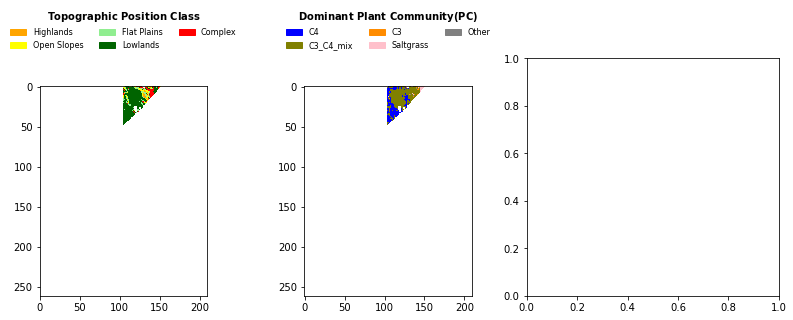

In [81]:
from matplotlib.gridspec import GridSpec
from matplotlib import colors, cm
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1 import make_axes_locatable


tpc_labels = ['Complex' if x == 'Other' else x for x in tpc_dict.keys()]

tpc_cmap = colors.ListedColormap(['orange', 'yellow', 'lightgreen', 'darkgreen', 'red'])
tpc_patches =[mpatches.Patch(color=c, label=list(tpc_labels)[i]) for i, c in enumerate(tpc_cmap.colors)]

pc_dmt_cmap = colors.ListedColormap(['blue', 'olive', 'darkorange', 'pink', 'grey'])
pc_patches =[mpatches.Patch(color=c, label=list(pc_dmt_dict.keys())[i]) for i, c in enumerate(pc_dmt_cmap.colors)]

rel_use_breaks = [0, 0.001, 0.5, 0.75, 0.9, 1.0, 1.25, 2.5, 4.0, 1000]
rel_use_labels = ['None', '', 'Low', '', 'Avg.', '', 'Hi', '', 'V. Hi', '']
rel_use_cmap = cm.get_cmap('Spectral_r', len(rel_use_breaks))
res_use_patches =[mpatches.Patch(color=rel_use_cmap(i), 
                                   label=rel_use_labels[i]) for i in np.arange(len(rel_use_labels))]
# Create the colormap
cmap_rel_use = colors.LinearSegmentedColormap.from_list(
            'Relative use', [rel_use_cmap(i) for i in np.arange(len(rel_use_labels))],
    N=len(rel_use_labels))
norm_rel_use = colors.BoundaryNorm(rel_use_breaks, len(rel_use_breaks))

yr = 2017
xr_dat_early = xr_dat_past.sel(Year=yr, season='early')
xr_dat_mid = xr_dat_past.sel(Year=yr, season='mid')
xr_dat_late = xr_dat_past.sel(Year=yr, season='late')

cax_fsize=8
cax_title_fsize=10
cax_pad=0.10

fig = plt.figure(figsize=(14, 10))

gs1 = GridSpec(1, 3, top=0.98, bottom=0.65, wspace=0.05)
ax1 = fig.add_subplot(gs1[0])
ax2 = fig.add_subplot(gs1[1])
ax3 = fig.add_subplot(gs1[2])
ax1.imshow(xr_dat_early['TPC_val'].sortby('UTM_Y', ascending=False).data, cmap=tpc_cmap)
ax1.legend(handles=tpc_patches, ncol=3, bbox_to_anchor=(0.5, 1.4), fontsize=8, 
           loc='upper center', frameon=False,
           title="$\\bf{Topographic\ Position\ Class}$", title_fontsize=10)
divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes('top', size='10%', pad=cax_pad)
cax1.axes.set_visible(False)

ax2.imshow(xr_dat_early['PC_dmt_val'].sortby('UTM_Y', ascending=False).data, cmap=pc_dmt_cmap)
ax2.legend(handles=pc_patches, ncol=3, bbox_to_anchor=(0.5, 1.4), fontsize=8, 
           loc='upper center', frameon=False,
           title="$\\bf{Dominant\ Plant\ Community (PC)}$", title_fontsize=10)
divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes('top', size='10%', pad=cax_pad)
cax2.axes.set_visible(False)

im3 = ax3.imshow(xr_dat_early['PC_div_orig'].sortby('UTM_Y', ascending=False).data, cmap='cividis', vmin=0.0, vmax=1.5)
divider3 = make_axes_locatable(ax3)
cax3 = divider3.append_axes('top', size='10%', pad=cax_pad)
cbar3 = fig.colorbar(im3, cax=cax3, orientation='horizontal')
cax3.xaxis.set_ticks_position('top')
cax3.set_title("$\\bf{PC\ Diversity\ (Shannon\ H)}$", fontsize=10)
cbar3.ax.tick_params(labelsize=8)

gs2 = GridSpec(3, 3, top=0.65, bottom=0.02, hspace=0.01)
ax4 = fig.add_subplot(gs2[0, 0])
ax5 = fig.add_subplot(gs2[0, 1])
ax6 = fig.add_subplot(gs2[0, 2])
im4 = ax4.imshow(xr_dat_early['Biomass_orig'].sortby('UTM_Y', ascending=False).data, cmap='magma', vmin=200, vmax=2500)
divider4 = make_axes_locatable(ax4)
cax4 = divider4.append_axes('top', size='10%', pad=cax_pad)
cbar4 = fig.colorbar(im4, cax=cax4, orientation='horizontal')
cax4.xaxis.set_ticks_position('top')
cax4.set_title("$\\bf{Biomass\ (kg/ha)}$", fontsize=10)
cbar4.ax.tick_params(labelsize=8)
#cax4left = divider4.append_axes('left', size='5%', pad=0.05)
#cax4left.yaxis.set_label("early-season")

im5 = ax5.imshow(xr_dat_early['CP_orig'].sortby('UTM_Y', ascending=False).data, cmap='viridis', vmin=6, vmax=12)
divider5 = make_axes_locatable(ax5)
cax5 = divider5.append_axes('top', size='10%', pad=cax_pad)
cbar5 = fig.colorbar(im5, cax=cax5, orientation='horizontal')
cax5.xaxis.set_ticks_position('top')
cax5.set_title("$\\bf{Crude\ Protein\ (\%)}$", fontsize=10)
cbar5.ax.tick_params(labelsize=8)

im6 = ax6.imshow(xr_dat_early['grazing_rel_freq'].sortby('UTM_Y', ascending=False).data, cmap=cmap_rel_use, norm=norm_rel_use)
divider6 = make_axes_locatable(ax6)
cax6 = divider6.append_axes('top', size='10%', pad=cax_pad)
cbar6 = fig.colorbar(im6, cax=cax6, orientation='horizontal')
cax6.xaxis.set_ticks_position('top')
cax6.set_title("$\\bf{Relative\ use}$", fontsize=10)
cbar6.ax.tick_params(labelsize=8)
cbar6.ax.set_xticklabels(rel_use_labels)

ax8 = fig.add_subplot(gs2[1, 0])
ax9 = fig.add_subplot(gs2[1, 1])
ax10 = fig.add_subplot(gs2[1, 2])
ax8.imshow(xr_dat_mid['Biomass_orig'].sortby('UTM_Y', ascending=False).data, cmap='magma', vmin=200, vmax=2500)
ax9.imshow(xr_dat_mid['CP_orig'].sortby('UTM_Y', ascending=False).data, cmap='viridis', vmin=6, vmax=12)
ax10.imshow(xr_dat_mid['grazing_rel_freq'].sortby('UTM_Y', ascending=False).data, cmap=cmap_rel_use, norm=norm_rel_use)

ax12 = fig.add_subplot(gs2[2, 0])
ax13 = fig.add_subplot(gs2[2, 1])
ax14 = fig.add_subplot(gs2[2, 2])
ax12.imshow(xr_dat_late['Biomass_orig'].sortby('UTM_Y', ascending=False).data, cmap='magma', vmin=200, vmax=2500)
ax13.imshow(xr_dat_late['CP_orig'].sortby('UTM_Y', ascending=False).data, cmap='viridis', vmin=6, vmax=12)
ax14.imshow(xr_dat_late['grazing_rel_freq'].sortby('UTM_Y', ascending=False).data, cmap=cmap_rel_use, norm=norm_rel_use)

for ax in [ax1, ax2, ax3, ax4, ax5, ax6, ax8, ax9, ax10, ax12, ax13, ax14]:
    #ax.axis('off')
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_frame_on(False)
    
ax1.set_ylabel("$\\bf{static}$", fontdict={'size': 12}, labelpad=15)
ax4.set_ylabel("$\\bf{early{-}season}$" + "\n(week 21)", fontdict={'size': 12}, labelpad=15)
ax8.set_ylabel("$\\bf{mid{-}season}$" + "\n(week 27)", fontdict={'size': 12}, labelpad=15)
ax12.set_ylabel("$\\bf{late{-}season}$" + "\n(week 33)", fontdict={'size': 12}, labelpad=15)


#plt.savefig('C:/Users/sean.kearney/OneDrive - USDA/Documents/Projects/GPS_v_hetgen/figures/Pasture_example_' + str(yr) + '_no_pred.png',
#            bbox_inches='tight', dpi=300)

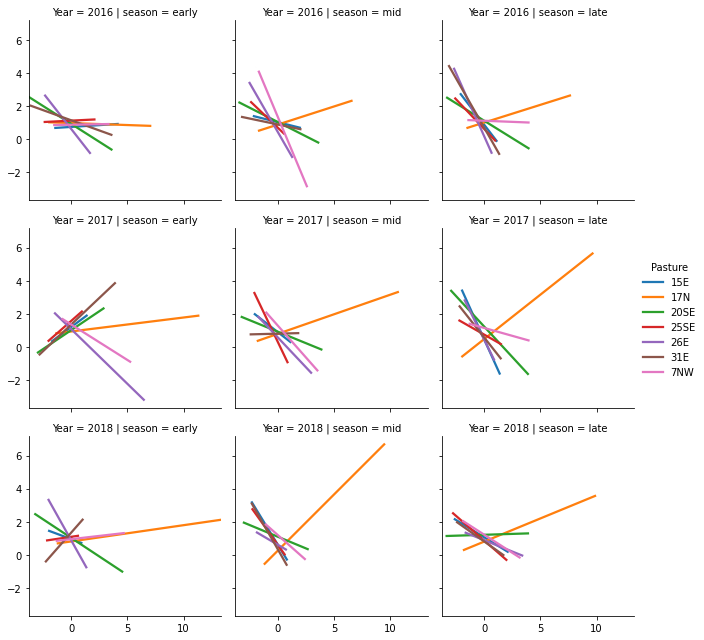

In [78]:
g = sns.FacetGrid(data=df_wkly_grid, col='season', row='Year', hue='Pasture')
g.map_dataframe(sns.regplot, x='Biomass', y='grazing_rel_freq', ci=None, scatter=False).add_legend()

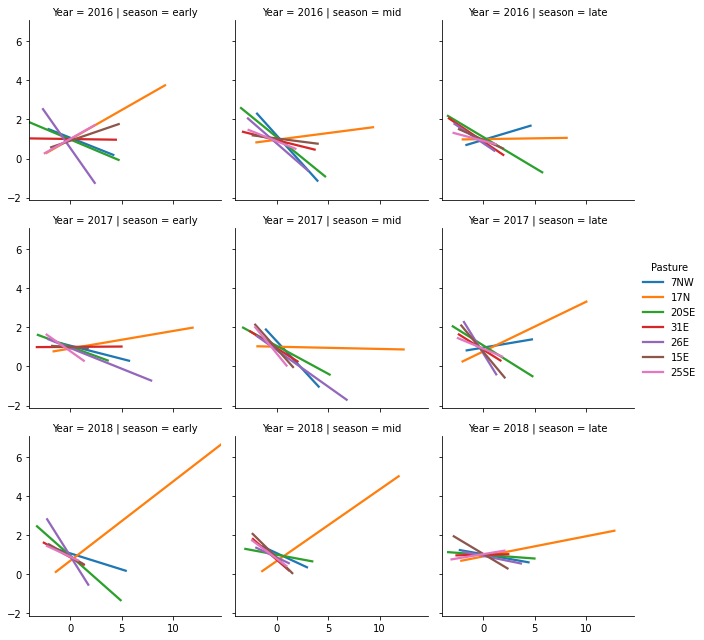

In [143]:
g = sns.FacetGrid(data=df_wkly_grid, col='season', row='Year', hue='Pasture')
g.map_dataframe(sns.regplot, x='Biomass', y='grazing_rel_freq', ci=None, scatter=False).add_legend()

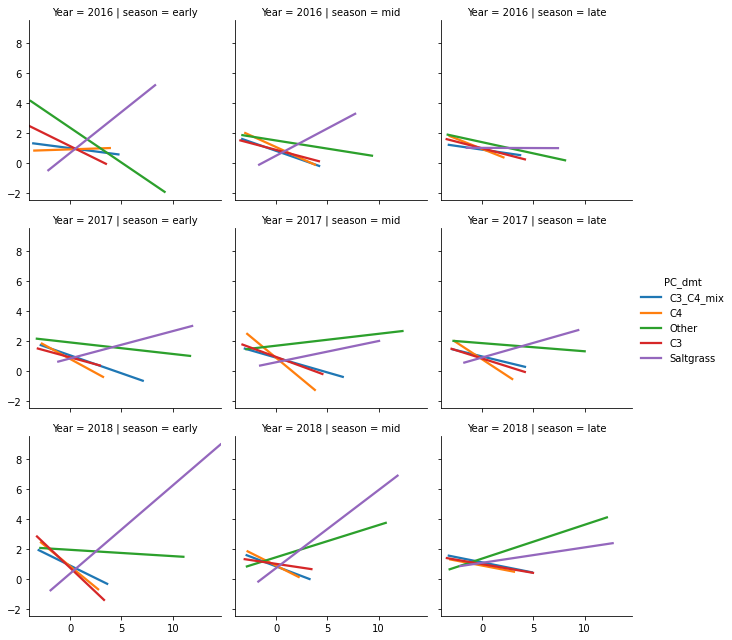

In [148]:
g = sns.FacetGrid(data=df_wkly_grid, col='season', row='Year', hue='PC_dmt')
g.map_dataframe(sns.regplot, x='Biomass', y='grazing_rel_freq', ci=None, scatter=False).add_legend()

In [34]:
"""
Build top models for each season across all pastures
"""
seas_mod_dict = {}
for seas in coefs['Season'].unique():
    print(seas)
    seas_mod_dict[seas] = {}
    for mod in tqdm(model_dict_fnl):
        form = model_dict_fnl[mod][seas]
        df_tmp = df_mods_tmp[(df_mods_tmp['season'] == seas) & (df_mods_tmp['Model'] == mod)]
        coefs_tmp = coefs[(coefs['Season'] == seas) & (coefs['Model'] == mod)][['week', 'Pasture', 'Param', 'coef']]
        md_tmp = NegativeBinomial.from_formula(form, df_tmp, offset=np.log(df_tmp['grazing_wkly_sum']), missing='drop')
        try:
            mdf_tmp = md_tmp.fit(maxiter=max_iters, method=fit_method, disp=False)
        except ValueError:
            mdf_tmp = md_tmp.fit(method="lbfgs")
        for idx, i in enumerate(mdf_tmp.params.index):
            mdf_tmp.params[idx] = coefs_tmp.groupby(
                ['week', 'Pasture', 'Param']).mean().reset_index().groupby('Param').mean().loc[i]['coef']
        coefs_ci = coefs_tmp.groupby('Param')['coef'].apply(lambda x: sms.DescrStatsW(x).tconfint_mean()).reindex(mdf_tmp.conf_int().index)
        mdf_tmp.conf_int()[0] = coefs_ci.apply(lambda x: x[0])
        mdf_tmp.conf_int()[1] = coefs_ci.apply(lambda x: x[1])
        seas_mod_dict[seas][mod] = mdf_tmp        

early


  0%|          | 0/8 [00:00<?, ?it/s]

mid


  0%|          | 0/8 [00:00<?, ?it/s]

late


  0%|          | 0/8 [00:00<?, ?it/s]

In [35]:
"""
Build top models for each season and for each pasture
"""
past_mod_dict = {}
for past in coefs['Pasture'].unique():
    print(past)
    past_mod_dict[past] = {}
    for seas in tqdm(coefs['Season'].unique()):
        past_mod_dict[past][seas] = {}
        for mod in model_dict_fnl:
            form = model_dict_fnl[mod][seas]
            df_tmp = df_mods_tmp[(df_mods_tmp['Pasture'] == past) & 
                                 (df_mods_tmp['season'] == seas) &
                                 (df_mods_tmp['Model'] == mod)]
            coefs_tmp = coefs[(coefs['Pasture'] == past) & 
                              (coefs['Season'] == seas) & 
                              (coefs['Model'] == mod)][['week', 'Pasture', 'Param', 'coef']]
            md_tmp = NegativeBinomial.from_formula(form, df_tmp, offset=np.log(df_tmp['grazing_wkly_sum']), missing='drop')
            try:
                mdf_tmp = md_tmp.fit(maxiter=max_iters, method=fit_method, disp=False)
            except ValueError:
                mdf_tmp = md_tmp.fit(method="lbfgs")
            for idx, i in enumerate(mdf_tmp.params.index):
                mdf_tmp.params[idx] = coefs_tmp.groupby(
                    ['week', 'Param']).mean().reset_index().groupby('Param').mean().loc[i]['coef']
            coefs_ci = coefs_tmp.groupby('Param')['coef'].apply(lambda x: sms.DescrStatsW(x).tconfint_mean()).reindex(mdf_tmp.conf_int().index)
            mdf_tmp.conf_int()[0] = coefs_ci.apply(lambda x: x[0])
            mdf_tmp.conf_int()[1] = coefs_ci.apply(lambda x: x[1])
            past_mod_dict[past][seas][mod] = mdf_tmp        

15E


  0%|          | 0/3 [00:00<?, ?it/s]

17N


  0%|          | 0/3 [00:00<?, ?it/s]

20SE


  0%|          | 0/3 [00:00<?, ?it/s]

26E


  0%|          | 0/3 [00:00<?, ?it/s]

31E


  0%|          | 0/3 [00:00<?, ?it/s]

7NW


  0%|          | 0/3 [00:00<?, ?it/s]

In [38]:
for seas in seas_mod_dict:
    for m in seas_mod_dict[seas]:
        seas_mod_dict[seas][m].save(os.path.join(outDIR, 'seas/', 'grazing_intensity_mod_full_' + seas + '_' + m + '.pkl'))
    if not os.path.exists(os.path.join(outDIR, 'past/')):
        os.mkdir(os.path.join(outDIR, 'past/'))
    for past in past_mod_dict:
        for m in past_mod_dict[past][seas]:
            past_mod_dict[past][seas][m].save(os.path.join(outDIR, 'past/', 'grazing_intensity_mod_full_' + past + '_' + seas + '_' + m + '.pkl'))

In [41]:
"""
Print out all combos of Pastures available for each week across a set range of weeks
"""
df_seas_unique = df_wkly_grid_full.groupby(['Year', 'week']).agg({'Pasture': lambda x: x.unique(),
                                                                  'Steer_ID': lambda x: x.unique()}).reset_index()
df_seas = df_seas_unique.groupby(['Year', 'week']).agg(
    {'Pasture': lambda x: [i for i in list(df_wkly_grid_full['Pasture'].unique()) if all(i in y for y in x)],
     'Steer_ID': lambda x: [i for i in list(df_wkly_grid_full['Steer_ID'].unique()) if all(i in y for y in x)]}).reset_index()
df_seas['season'] = df_seas['week'].apply(lambda x: season_func(x))
df_seas

,Year,week,Pasture,Steer_ID,season
0,2016,19,[24W],"[3770_D1_2016, 3771_D1_2016]",early
1,2016,20,"[24W, 5E, 7NW, 17N, 19N, 20SE, 31E, 26E]","[3770_D1_2016, 3771_D1_2016, 2285_D1_2016, 228...",early
2,2016,21,"[24W, 5E, 7NW, 17N, 19N, 20SE, 31E, 26E, 15E]","[3770_D1_2016, 3771_D1_2016, 2285_D1_2016, 228...",early
3,2016,22,"[5E, 7NW, 17N, 19N, 20SE, 31E, 26E, 15E, 25SE]","[2285_D1_2016, 2286_D1_2016, 2288_D1_2016, 228...",early
4,2016,23,"[24W, 5E, 7NW, 17N, 19N, 20SE, 31E, 26E, 15E, ...","[3770_D1_2016, 3771_D1_2016, 2285_D1_2016, 228...",early
5,2016,24,"[24W, 5E, 7NW, 17N, 19N, 20SE, 31E, 15E, 25SE]","[3770_D1_2016, 3771_D1_2016, 2285_D1_2016, 228...",early
6,2016,25,"[24W, 5E, 7NW, 17N, 19N, 20SE, 31E, 26E, 15E, ...","[3770_D1_2016, 2285_D1_2016, 2286_D1_2016, 228...",early
7,2016,27,"[24W, 5E, 7NW, 17N, 19N, 20SE, 31E, 26E, 15E, ...","[2285_D2_2016, 2286_D2_2016, 2287_D2_2016, 228...",mid
8,2016,28,"[24W, 5E, 7NW, 17N, 19N, 20SE, 31E, 15E, 25SE]","[2285_D2_2016, 2286_D2_2016, 2287_D2_2016, 228...",mid
9,2016,29,"[24W, 5E, 7NW, 17N, 19N, 20SE, 31E, 26E, 15E, ...","[2285_D2_2016, 2286_D2_2016, 2287_D2_2016, 228...",mid


In [73]:
# specific final pastures
#fnl_pastures = ['7NW', '17N', '20SE', '15E', '26E', '31E']
fnl_pastures = ['19N', '20SE', '31E', '26E', '15E', '25SE']

# create mask of final weeks based on pastures
wk_mask = [all(j in i for j in fnl_pastures) for i in df_seas['Pasture']]

# check which weeks are in final dataset
df_seas[wk_mask].groupby(['Year', 'season'])['week'].count().reset_index()

,Year,season,week
0,2016,early,3
1,2016,late,5
2,2016,mid,5
3,2017,early,2
4,2017,late,4
5,2017,mid,1
6,2018,late,4
7,2018,mid,1


In [52]:
#past_combos
past_combos_sum = np.array(
        [sum(all(elem in test2 for elem in test1) for test2 in df_seas['Pasture']) for test1 in past_combos])
top_combos = np.array(past_combos)[(past_combos_sum == np.max(past_combos_sum)) | (past_combos_sum > 5)]

In [66]:
for combo in past_combos:
    print(list(combo))

['24W', '5E', '7NW', '17N', '19N', '20SE']
['24W', '5E', '7NW', '17N', '19N', '31E']
['24W', '5E', '7NW', '17N', '19N', '26E']
['24W', '5E', '7NW', '17N', '19N', '15E']
['24W', '5E', '7NW', '17N', '19N', '25SE']
['24W', '5E', '7NW', '17N', '20SE', '31E']
['24W', '5E', '7NW', '17N', '20SE', '26E']
['24W', '5E', '7NW', '17N', '20SE', '15E']
['24W', '5E', '7NW', '17N', '20SE', '25SE']
['24W', '5E', '7NW', '17N', '31E', '26E']
['24W', '5E', '7NW', '17N', '31E', '15E']
['24W', '5E', '7NW', '17N', '31E', '25SE']
['24W', '5E', '7NW', '17N', '26E', '15E']
['24W', '5E', '7NW', '17N', '26E', '25SE']
['24W', '5E', '7NW', '17N', '15E', '25SE']
['24W', '5E', '7NW', '19N', '20SE', '31E']
['24W', '5E', '7NW', '19N', '20SE', '26E']
['24W', '5E', '7NW', '19N', '20SE', '15E']
['24W', '5E', '7NW', '19N', '20SE', '25SE']
['24W', '5E', '7NW', '19N', '31E', '26E']
['24W', '5E', '7NW', '19N', '31E', '15E']
['24W', '5E', '7NW', '19N', '31E', '25SE']
['24W', '5E', '7NW', '19N', '26E', '15E']
['24W', '5E', '7NW

In [7]:
if len(reqd_pastures) > 0:
    reqd_mask = [all(p in x for p in reqd_pastures) for x in top_combos]
    top_combos = top_combos[reqd_mask]
top_combos = [list(x) for x in top_combos]
top_dates = []
for combo in top_combos:
    mask = [all(j in i for j in combo) for i in df_seas['Pasture']]
    top_dates.append(
        [datetime.date.fromisocalendar(2017, x, 1).strftime('%b %d') for x in df_seas['week'][mask].values])
print('\n\n' + '-------------------------------------' + '\n' + 
      'No. Pastures: ' + str(r) + '\n'
      'Max no. weeks: ' + str(np.max(past_combos_sum)) + '\n' +
      '-------------------------------------')
for dates, combo in [(y, x) for y, x in sorted(zip(top_dates, top_combos), key=lambda pair: len(pair[0]), reverse=True)]:
    print('Pastures=' + str(len(combo)) + ': ' + str(combo))
    past_mask = [all(j in i for j in combo) for i in df_seas['Pasture']]
    #steer_mask = [all([j in y] for y in i for j in combo) for i in df_gps_wkly['Pasture_Steer_ID']]
    steer_ct = [sum([sum([j in y for j in combo]) for y in x]) for x in df_seas['Steer_ID'][past_mask]]
    #steers = [len(x) for x in df_gps_wkly['Pasture_Steer_ID'][steer_mask]]
    #dates = [datetime.date.fromisocalendar(2017, x, 1).strftime('%B %d') for x in df_gps_wkly['week'][mask].values]
    print('Weeks=' + str(len(dates)) + ' (start dates): ' + str(dates))
    print('Steers: ' + str(steer_ct) + '\n')



-------------------------------------
No. Pastures: 6
Max no. weeks: 22
-------------------------------------
Pastures=6: ['7NW', '17N', '19N', '20SE', '31E', '15E']
Weeks=22 (start dates): ['May 22', 'May 29', 'Jun 05', 'Jun 12', 'Jun 19', 'Jul 03', 'Jul 10', 'Jul 17', 'Jul 24', 'Jul 31', 'Aug 07', 'Aug 14', 'Aug 21', 'Sep 11', 'Sep 18', 'Sep 25', 'May 22', 'May 29', 'Jul 31', 'Sep 11', 'Sep 18', 'Sep 25']
Steers: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Pastures=6: ['7NW', '17N', '20SE', '31E', '26E', '15E']
Weeks=22 (start dates): ['May 22', 'May 29', 'Jun 05', 'Jun 19', 'Jul 03', 'Jul 17', 'Jul 24', 'Jul 31', 'Aug 07', 'Aug 14', 'Aug 21', 'Sep 11', 'Sep 18', 'Sep 25', 'May 22', 'May 29', 'Jun 05', 'Jul 10', 'Jul 24', 'Jul 31', 'Sep 11', 'Sep 18']
Steers: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Pastures=6: ['17N', '19N', '20SE', '31E', '15E', '25SE']
Weeks=22 (start dates): ['May 29', 'Jun 05', 'Jun 12', 'Jun 19', 'Jul 03', 'J